In [1]:
import math
import sys
import numpy as np
from scipy.integrate import simps
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
from six.moves import cPickle as pickle
from scipy.spatial.distance import cosine

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


In [2]:
# Helper functions
def unpickle_data(pickle_file):
    """
    Unpickles the data from a pickle file
    """
    f = open(pickle_file, 'rb')
    return pickle.load(f)

def populate_data_dict(data_dict, key, pickle_file):
    """
    Given a key populates a dictionary
    """
    data_dict[key] = unpickle_data(pickle_file)
    
    
def populate_k_shot_acc_dict(data_dict, key, k_shot_dict):
    num_runs = data_dict[key]['mean'].shape[0]
    k_shot_dict[key] = []
    for run in range(num_runs):
        key_acc = data_dict[key]['mean'][run]
        num_batches = key_acc.shape[1]
        num_tasks = key_acc.shape[0]
        k_shot_acc = np.zeros([num_batches], dtype=np.float32)
        for i in range(num_batches):
            acc = 0.0
            for j in range(num_tasks):
                acc += key_acc[j,i,j]
            k_shot_acc[i] = acc/ num_tasks
        
        k_shot_dict[key].append(k_shot_acc)
        
    k_shot_dict[key] = np.array(k_shot_dict[key])

def populate_k_shot_acc_dict_with_varying_batches(data_dict, key, k_shot_dict):
    num_runs = data_dict[key]['mean'].shape[0]
    k_shot_dict[key] = []
    for run in range(num_runs):
        key_acc = data_dict[key]['mean'][run]
        num_tasks = key_acc.shape[0]
        # First compute the number of batches for each task (as total number of examples per task is different)
        batches_per_task = []
        for i in range(num_tasks):
            batches_per_task.append(np.max(np.nonzero(np.sum(key_acc[i], axis=1))))

        # Since the code above returned an index, so add '1' to get the count of batches for each task
        batches_per_task = np.array(batches_per_task) + 1
        max_batches = np.max(batches_per_task)
        k_shot_acc = np.zeros([max_batches], dtype=np.float32)
    
        for i in range(max_batches):
            acc = 0.0
            task_count_with_this_batch = 0
            for j in range(num_tasks):
                if i < batches_per_task[j]: # Only add accuracy if current task has that many batches
                    acc += key_acc[j,i,j]
                    task_count_with_this_batch += 1
                else:
                    acc += key_acc[j,batches_per_task[j]-1,j]
            k_shot_acc[i] = acc/ num_tasks
        
        # Store the average accuracy in the dictionary
        k_shot_dict[key].append(k_shot_acc)
    
    k_shot_dict[key] = np.array(k_shot_dict[key])
    
    return batches_per_task    


def compute_fgt(acc, key):
    num_tasks = acc.shape[0] # Number of tasks
    last_batch_dim = acc.shape[1] - 1 # Last batch dimension
    fgt_msr = np.zeros([num_tasks-1]) # Not defined for first task. Store forgetting after each task
    worst_case_fgt = np.zeros([num_tasks-1]) # Not defined for first task. Store forgetting after each task
    for i in range(num_tasks):
        if i == 0:
            pass
        else:
            wst_fgt_i = []
            fgt_i = 0.0
            for j in range(i):
                if key == 'GEM' or key == 'ICARL':
                    fgt_per_task = np.amax(acc[:i,j]) - acc[i,j]
                else:
                    fgt_per_task = np.amax(acc[:i,last_batch_dim,j]) - acc[i,last_batch_dim,j]
                        
                fgt_i += fgt_per_task
                wst_fgt_i.append(fgt_per_task)
            fgt_msr[i-1] = fgt_i/ (j+1)
            wst_fgt_i = np.array(wst_fgt_i)
            worst_case_fgt[i-1] = np.max(wst_fgt_i)
                
    return fgt_msr, worst_case_fgt  


def compute_fgt_with_varying_batches(data_dict, batches_per_task):
    fgt_msr = dict()
    for key in data_dict:
        acc = data_dict[key]
        num_tasks = acc.shape[0] # Number of tasks
        last_batch_acc_for_all_tasks = np.zeros([num_tasks, num_tasks])
        
        # Compute the last batch performance for each task
        for i in range(num_tasks):
            last_batch_acc_for_all_tasks[i] = acc[i][batches_per_task[i]-1]
        
        fgt_msr[key] = np.zeros([num_tasks-1]) # Not defined for first task. Store forgetting after each task
        for i in range(num_tasks):
            if i == 0:
                pass
            else:
                fgt_i = 0.0
                for j in range(i):
                    fgt_i += (np.amax(last_batch_acc_for_all_tasks[:i,j]) - last_batch_acc_for_all_tasks[i,j])
                fgt_msr[key][i-1] = fgt_i/ (j+1)
                
    return fgt_msr

def average_acc_stats_across_runs(data, key):
    """
    Compute the average accuracy statistics (mean and std) across runs
    """
    num_runs = data.shape[0]
    avg_acc = np.zeros(num_runs)
    for i in range(num_runs):
        if key == 'GEM':
            avg_acc[i] = np.mean(data[i][-1])
        else:
            avg_acc[i] = np.mean(data[i][-1, -1])
        
    return avg_acc.mean()*100, avg_acc.std()*100

def average_fgt_stats_across_runs(data, key):
    """
    Compute the forgetting statistics (mean and std) across runs
    """
    num_runs = data.shape[0]
    fgt = np.zeros(num_runs)
    wst_fgt = np.zeros(num_runs)
    for i in range(num_runs):
        fgt_i, wst_fgt_i = compute_fgt(data[i], key)
        #print('{}, {}'.format(i, fgt_i))
        fgt[i] = fgt_i[-1]
        wst_fgt[i] = wst_fgt_i[-1]
        
    return fgt.mean(), fgt.std(), wst_fgt.mean(), wst_fgt.std()
        

def plot_k_shot_performance_task_view(n, data_dict, keys, plt_name):
    plt.figure(figsize=(14, 7))
    num_windows = len(keys)
    for i, key in enumerate(keys):
        data = data_dict[key]
        num_tasks = data.shape[0]
        plt.subplot(math.ceil((num_windows+1)/2), math.ceil((num_windows+1)/2), (i+1))
        for k in range(n):
            acc = np.zeros([num_tasks])
            for task in range(num_tasks):
                acc[task] = data[task, k, task]
            plt.plot(np.arange(1,num_tasks+1), acc, label='%d-shot'%(k))
        plt.xlabel('Tasks-%s'%(key))
        plt.ylabel('Avg_Acc')
        plt.xticks(np.arange(1, num_tasks+1))
    plt.tight_layout()
    #plt.legend(loc='best')
    plt.legend(loc=6, bbox_to_anchor=(1, 0.5))
    plt.savefig(plt_name)
    
def plot_k_shot_performance_method_view(n, data_dict, plt_name):
    plt.figure(figsize=(14, 7))
    for k in range(n):
        plt.subplot(n//2, n//2, (k+1))
        for i, key in enumerate(data_dict):
            num_tasks = data_dict[key].shape[0]
            acc = np.zeros(num_tasks)
            for task in range(num_tasks):
                acc[task] = data_dict[key][task, k, task]
            plt.plot(np.arange(1,num_tasks+1), acc, label=key)
        plt.xlabel('Tasks(%d-shot)'%(k))
        plt.ylabel('Avg_Acc')
        plt.xticks(np.arange(1, num_tasks+1))
    plt.tight_layout()
    plt.legend(loc='best')
    #plt.savefig(plt_name)    
    

In [3]:
def plot_average_accuracy_along_training_path(data_mean, plot_name=None, is_cifar=False):
    """
    Plot the average accuracy along the training path
    """
    plt.clf()
    K_FOR_CROSS_VAL = 3
    avg_acc_dict = dict()
    for key in data_mean:
        if key == 'ICARL':
            data = data_mean[key]
            num_tasks = data.shape[0] - K_FOR_CROSS_VAL
        else:
            data = data_mean[key]['mean'].mean(0)
            num_tasks = data.shape[0]
        avg_acc = np.zeros(num_tasks)
        for i in range(num_tasks):
            if key == 'MULTI-TASK':
                avg_acc[i] = np.mean(data)
            elif key == 'ICARL':
                avg_acc[i] = np.mean(data[i,:i+1])
            elif key == 'GEM':
                avg_acc[i] = np.mean(data[i,:i+1])
            else:
                avg_acc[i] = np.mean(data[i,-1,:i+1])
        print(key, avg_acc[-1])
        avg_acc_dict[key] = avg_acc

    
    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])
    tasks = np.arange(1, num_tasks+1)
    
    colors = {'MULTI-TASK':'-k', 'VAN': 'C0', 'ICARL':'C1', 'EWC': '-m', 'PI': '-b', 'MAS': '-y', 
              'RWALK':'-g', 'PROG-NN':'C5--', 'GEM':'-c', 'A-GEM':'-r', 'MER': 'C6'}
    
        
    for i, key in enumerate(data_mean):
        if key == 'MULTI-TASK':
            continue
        else:
            if key == 'A-GEM':
                ax.plot(tasks, avg_acc_dict[key],'%s'%(colors[key]), marker='^', markersize=7, lw=2, label=key)
            else:
                ax.plot(tasks, avg_acc_dict[key],'%s'%(colors[key]), lw=2, label=key)
                
    line, =  ax.plot(tasks, avg_acc_dict['MULTI-TASK'],'%s'%(colors['MULTI-TASK']), lw=2, label='MULTI-TASK')
    line.set_dashes([2, 2, 10, 2])
        
    if is_cifar:
        ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
    
    ax.set_xlabel('Tasks', size=20)
    ax.set_ylabel('Avg Accuracy', size=20)
    plt.xticks(tasks)
    plt.grid()

    
    if plot_name is not None:
        plt.savefig(plot_name)
    else:
        plt.show()

In [4]:
def get_zero_shot_perf(data_mean_ohot, data_mean_je):
    """
    Plot the zero-shot performance against the number of tasks
    """
    zero_shot_ohot_perf = dict()
    zero_shot_je_perf = dict()
    
    for key in data_mean_ohot:
        if key == 'MULTI-TASK' or key == 'GEM':
            continue
        
        data_ohot = data_mean_ohot[key]['mean'].mean(0)
        data_je = data_mean_je[key]['mean'].mean(0)
        num_tasks = data_ohot.shape[0] 
        
        zst_ohot_perf = np.zeros(num_tasks)
        zst_je_perf = np.zeros(num_tasks)
        
        #if (data_ohot.shape[0] != num_tasks) or (data_je.shape[0] != num_tasks):
        #    continue
            
        for i in range(num_tasks):
            zst_ohot_perf[i] = data_ohot[i,0,i]
            zst_je_perf[i] = data_je[i,0,i]
            
        zero_shot_ohot_perf[key] = zst_ohot_perf
        zero_shot_je_perf[key] = zst_je_perf
    
    return zero_shot_ohot_perf, zero_shot_je_perf
        

In [5]:
def bar_plot_k_shot_performance(data_dict, shot, is_cifar=False, plt_name=None):
    num_tasks = data_dict['VAN'].shape[0]
    ind = np.arange(1, num_tasks+1) # the x locations for the groups
    width = 0.15 # the width of the bars
    colors = ['r', 'g', 'b', 'c', 'y']
    plt.clf()
    for col_ind, key in enumerate(data_dict):
        acc = np.zeros([num_tasks])
        for task in range(num_tasks):
            acc[task] = data_dict[key][task,shot,task]
        p1 = plt.bar(ind+width*col_ind, acc, width, color='%s'%(colors[col_ind]), bottom=0, label=key)
    
    plt.xticks(np.arange(1, num_tasks+1)) # add loads of ticks

    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.5 # inch margin
    s = maxsize/plt.gcf().dpi*num_tasks+10*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
    
    if is_cifar:
        plt.title('%d-Shot Performance'%(shot*5))
    else:
        plt.title('%d-Shot Performance'%(shot))
    plt.legend(loc=6, bbox_to_anchor=(1, 0.8))
    plt.xlabel('Tasks')
    plt.ylabel('Avg_Acc')    
    #plt.show()
    plt.savefig(plt_name)
    

# PERMUTE MNIST

In [37]:
PREFIX = '/Users/arslanch/Dropbox/lll/final_results/mnist/'
multi_task_pickle = PREFIX+'multi_task/PERMUTE_MNIST_HERDING_False_FC-S_False_True_VAN_0_0_10_False_25-18-09-10-10-41.pickle'
van_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_VAN_0_0_10_False_25-18-11-08-16-40.pickle'
ewc_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_EWC_10_0_10_False_25-18-11-08-17-55.pickle'
mas_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_MAS_0_1_10_False_25-18-11-08-16-40.pickle'
rwalk_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_RWALK_1_0_10_False_25-18-11-08-18-06.pickle'
pnn_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_PNN_0_0_10_False_25-18-11-08-16-40.pickle'
gem_pickle = PREFIX+'gem_mnist_5_runs.pickle'
a_gem_pickle = PREFIX+'PERMUTE_MNIST_HERDING_False_FC-S_False_True_A-GEM_0_0_10_False_25-18-11-08-19-27.pickle'

NUM_RUNS = 5
MODELS = ['MULTI-TASK', 'VAN', 'EWC', 'MAS', 'RWALK', 'PNN', 'GEM', 'A-GEM']

In [38]:
data_mean = dict()
populate_data_dict(data_mean, 'MULTI-TASK', multi_task_pickle)
populate_data_dict(data_mean, 'VAN', van_pickle)
populate_data_dict(data_mean, 'EWC', ewc_pickle)
populate_data_dict(data_mean, 'MAS', mas_pickle)
populate_data_dict(data_mean, 'RWALK', rwalk_pickle)
populate_data_dict(data_mean, 'PROG-NN', pnn_pickle)
populate_data_dict(data_mean, 'GEM', gem_pickle)
populate_data_dict(data_mean, 'A-GEM', a_gem_pickle)


avg_k_shot_acc = dict()
populate_k_shot_acc_dict(data_mean, 'VAN', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'EWC', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'MAS', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'RWALK', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'PROG-NN', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'A-GEM', avg_k_shot_acc)

('MAS', 0.6985364556312561)
('VAN', 0.47952938079833984)
('MULTI-TASK', 0.9537960290908813)
('PROG-NN', 0.9354565143585205)
('EWC', 0.6834882497787476)
('A-GEM', 0.8911787867546082)
('RWALK', 0.857968270778656)
('GEM', 0.8958470588235294)


<Figure size 432x288 with 0 Axes>

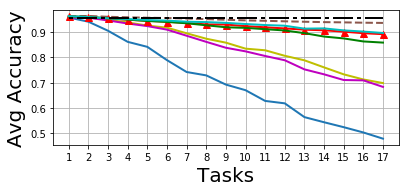

In [13]:
plot_average_accuracy_along_training_path(data_mean, 'iclr_plots/mnist_average_accuracy.pdf')

### Average Accuracy and Forgetting Measure

In [39]:
for key in data_mean:
    if key == 'MULTI-TASK':
        print('{}: {}'.format(key, np.mean(data_mean[key]['mean'][-1])))
    else:
        acc_mean, acc_std = average_acc_stats_across_runs(data_mean[key]['mean'], key)
        fgt_mean, fgt_std, wst_fgt_mean, wst_fgt_std = average_fgt_stats_across_runs(data_mean[key]['mean'], key)
        print('{}=> Acc: {} (+-{}), Fgt: {} (+-{}), Wst Fgt: {} (+-{})'.format(key, acc_mean, 
                                                                               acc_std, fgt_mean, 
                                                                               fgt_std, wst_fgt_mean, 
                                                                               wst_fgt_std))

MAS=> Acc: 69.8536467552 (+-0.934640017162), Fgt: 0.268572501838 (+-0.0100729938001), Wst Fgt: 0.587360012531 (+-0.027087299643)
VAN=> Acc: 47.9529416561 (+-1.317261874), Fgt: 0.510611252487 (+-0.0139219331308), Wst Fgt: 0.779999995232 (+-0.0271953681577)
MULTI-TASK: 0.953796029091
PROG-NN=> Acc: 93.5456466675 (+-0.0672649044055), Fgt: 0.0 (+-0.0), Wst Fgt: 0.0 (+-0.0)
EWC=> Acc: 68.3488249779 (+-0.688293326267), Fgt: 0.288316249475 (+-0.00747878974325), Wst Fgt: 0.578699982166 (+-0.0360688897624)
A-GEM=> Acc: 89.1178810596 (+-0.145538700981), Fgt: 0.0695875033736 (+-0.00146231043289), Wst Fgt: 0.13083999157 (+-0.00925085520745)
RWALK=> Acc: 85.7968246937 (+-0.568200764609), Fgt: 0.0820575013757 (+-0.00677982812048), Wst Fgt: 0.160260009766 (+-0.0298994666151)
GEM=> Acc: 90.2967058824 (+-0.149668884831), Fgt: 0.05532875 (+-0.00235690010925), Wst Fgt: 0.09684 (+-0.00717791055949)


### LCA Measure

In [9]:
num_iters = 55000/ 10
num_batches = []
for iters in range(num_iters):
    if (iters < 10) or (iters < 100 and iters % 10 == 0) or (iters % 100 == 0):
        num_batches.append(iters)
num_batches.append(num_iters)
gem_avg_k_shot = np.array([ 0.09812353,  0.1610647 ,  0.17345884,  0.20008238,  0.19457644,
        0.23791176,  0.26005882,  0.27361766,  0.30264702,  0.32512945,
        0.32201171])

BATCHES_WE_CARE = 10
num_runs = avg_k_shot_acc['VAN'].shape[0]
area_trapz = dict()
area_trapz['VAN'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['EWC'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['RWALK'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['MAS'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['PROG-NN'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['GEM'] = np.zeros(BATCHES_WE_CARE+1)
area_trapz['A-GEM'] = np.zeros([num_runs, BATCHES_WE_CARE+1])


for run in range(num_runs):
    for measure_upto in range(1, BATCHES_WE_CARE+2):
        batches_upto = num_batches[:measure_upto]
        if measure_upto == 1:
            area_trapz['VAN'][run][measure_upto-1] = avg_k_shot_acc['VAN'][run][0]
            area_trapz['EWC'][run][measure_upto-1] = avg_k_shot_acc['EWC'][run][0]
            area_trapz['RWALK'][run][measure_upto-1] = avg_k_shot_acc['RWALK'][run][0]
            area_trapz['MAS'][run][measure_upto-1] = avg_k_shot_acc['MAS'][run][0]
            area_trapz['PROG-NN'][run][measure_upto-1] = avg_k_shot_acc['PROG-NN'][run][0]
            area_trapz['GEM'][measure_upto-1] = gem_avg_k_shot[0]
            area_trapz['A-GEM'][run][measure_upto-1] = avg_k_shot_acc['A-GEM'][run][0]
        else:
            # Using trapezoidal rule
            max_acc = np.ones_like(batches_upto)
            max_area_trapz = np.trapz(max_acc, batches_upto)
            area_trapz['VAN'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['VAN'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['EWC'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['EWC'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['RWALK'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['RWALK'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['MAS'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['MAS'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['PROG-NN'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['PROG-NN'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['GEM'][measure_upto-1] = np.trapz(gem_avg_k_shot[:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['A-GEM'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['A-GEM'][run][:measure_upto], batches_upto)/ max_area_trapz
            
print('LCA_10 classification models:')
for key in area_trapz:
    if key == 'GEM':
        print('{}: {})'.format(key, area_trapz[key][10]))
    else:
        lca_10 = area_trapz[key][:, 10]
        print('{}: {} (+-{})'.format(key, lca_10.mean(), lca_10.std()))

LCA_10 classification models:
MAS: 0.294706057012 (+-0.00389778462622)
VAN: 0.26160264805 (+-0.00670447014861)
PROG-NN: 0.197896528393 (+-0.00618755975804)
EWC: 0.276040763855 (+-0.00317074618471)
A-GEM: 0.291115294695 (+-0.00459682817637)
RWALK: 0.316155999303 (+-0.00566788402049)
GEM: 0.233861469)


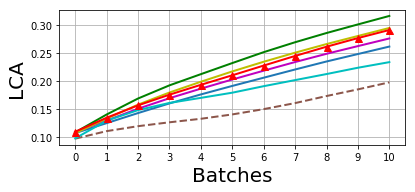

In [11]:
batches_we_care = np.arange(BATCHES_WE_CARE+1)
fig = plt.figure(figsize=(8, 2.5))
ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])

ax.plot(batches_we_care, np.mean(area_trapz['VAN'], axis=0),'C0', lw=2, label='VAN')
ax.plot(batches_we_care, np.mean(area_trapz['EWC'], axis=0),'-m', lw=2, label='EWC')
ax.plot(batches_we_care, np.mean(area_trapz['RWALK'], axis=0),'-g', lw=2, label='RWALK')
ax.plot(batches_we_care, np.mean(area_trapz['MAS'], axis=0),'-y', lw=2, label='MAS')
ax.plot(batches_we_care, np.mean(area_trapz['PROG-NN'], axis=0),'C5--', lw=2, label='PROG-NN')
ax.plot(batches_we_care, area_trapz['GEM'],'-c', lw=2, label='GEM')
ax.plot(batches_we_care, np.mean(area_trapz['A-GEM'], axis=0),'-r', marker='^', markersize=7, lw=2, label='A-GEM')


ax.set_xlabel('Batches', size=20)
ax.set_ylabel('LCA', size=20)
plt.xticks(batches_we_care)
#ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#ax.legend(loc='best', borderaxespad=0.2)
plt.grid()
#plt.show()
plt.savefig('iclr_plots/fam_mnist.pdf')

## CIFAR-100 (ResNet-18)

In [13]:
PREFIX = '/Users/arslanch/Dropbox/lll/final_results/cifar/'
multi_task_pickle = PREFIX+'multi_task/SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_VAN_0_0_0_03_10_False_13-18-09-10-11-18.pickle'
van_pickle = PREFIX+'SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_VAN_0_0_0_01_10_False_13-18-11-08-16-40.pickle'
ewc_pickle = PREFIX+'SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_EWC_10_0_0_03_10_False_13-18-11-08-17-05.pickle'
pi_pickle = PREFIX+'SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_PI_0_1_0_01_10_False_13-18-11-08-17-38.pickle'
mas_pickle = PREFIX+'SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_MAS_0_1_0_03_10_False_13-18-11-08-16-40.pickle'
rwalk_pickle = PREFIX+'SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_RWALK_1_0_0_03_10_False_13-18-11-08-17-16.pickle'
icarl_pickle = PREFIX+'icarl_split_cifar_1300.pickle'
pnn_pickle = PREFIX+'SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_PNN_0_0_0_03_10_False_13-18-11-08-16-40.pickle'
gem_pickle = PREFIX+'gem_cifar_5_runs.pickle'
a_gem_pickle = '/Users/arslanch/Dropbox/lll/average_results/cifar/SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_A-GEM_0_0_0_03_10_False_13-18-12-07-05-35.pickle'
MODELS = ['MULTI-TASK', 'VAN', 'EWC', 'PI', 'MAS', 'RWALK', 'GEM', 'ICARL', 'PNN','A-GEM']

In [14]:
data_mean = dict()
populate_data_dict(data_mean, 'MULTI-TASK', multi_task_pickle)
populate_data_dict(data_mean, 'VAN', van_pickle)
populate_data_dict(data_mean, 'EWC', ewc_pickle)
populate_data_dict(data_mean, 'PI', pi_pickle)
populate_data_dict(data_mean, 'RWALK', rwalk_pickle)
populate_data_dict(data_mean, 'MAS', mas_pickle)
populate_data_dict(data_mean, 'ICARL', icarl_pickle)
populate_data_dict(data_mean, 'PROG-NN', pnn_pickle)
populate_data_dict(data_mean, 'A-GEM', a_gem_pickle)
populate_data_dict(data_mean, 'GEM', gem_pickle)

avg_k_shot_acc = dict()
populate_k_shot_acc_dict(data_mean, 'VAN', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'PROG-NN', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'EWC', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'PI', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'RWALK', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'MAS', avg_k_shot_acc)
populate_k_shot_acc_dict(data_mean, 'A-GEM', avg_k_shot_acc)

('MAS', 0.4415294091491138)
('VAN', 0.42995294385096605)
('MULTI-TASK', 0.6826823353767395)
('PROG-NN', 0.5917176492073957)
('EWC', 0.42385882121675156)
('A-GEM', 0.6226588231675766)
('RWALK', 0.40865882161785577)
('ICARL', 0.5011764705882352)
('PI', 0.4711764703778659)
('GEM', 0.6122823529411764)


<Figure size 432x288 with 0 Axes>

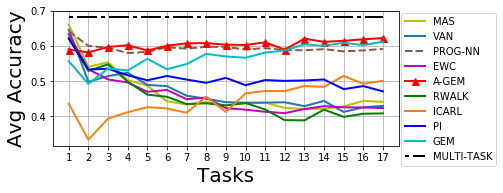

In [15]:
plot_average_accuracy_along_training_path(data_mean, 'iclr_plots/cifar_average_accuracy.pdf', is_cifar=True)

### Average Accuracy and Forgetting Measure

In [16]:
for key in data_mean:
    if key == 'MULTI-TASK':
        print('{}: {}'.format(key, np.mean(data_mean[key]['mean'][-1])))
    elif key == 'ICARL':
        acc_mean = np.mean(data_mean[key][16, :17])
        fgt_mean, wst_fgt_mean = compute_fgt(data_mean[key][:16, :17], key)
        print('{}=> Acc: {}, Fgt: {}, Wst Fgt: {})'.format(key, acc_mean, fgt_mean[-1], wst_fgt_mean[-1]))
    else:
        acc_mean, acc_std = average_acc_stats_across_runs(data_mean[key]['mean'], key)
        fgt_mean, fgt_std, wst_fgt_mean, wst_fgt_std = average_fgt_stats_across_runs(data_mean[key]['mean'], key)
        print('{}=> Acc: {} (+-{}), Fgt: {} (+-{}), Wst Fgt: {} (+-{})'.format(key, acc_mean, 
                                                                               acc_std, fgt_mean, 
                                                                               fgt_std, wst_fgt_mean, 
                                                                               wst_fgt_std))

MAS=> Acc: 44.1529409149 (+-2.38650158816), Fgt: 0.246675005741 (+-0.0221935474543), Wst Fgt: 0.479599994421 (+-0.0923592866289)
VAN=> Acc: 42.9952943851 (+-2.0688039504), Fgt: 0.244899995439 (+-0.0283089436285), Wst Fgt: 0.452799993753 (+-0.0579185526662)
MULTI-TASK: 0.682682335377
PROG-NN=> Acc: 59.1717649207 (+-0.853264944653), Fgt: 0.0 (+-0.0), Wst Fgt: 0.0 (+-0.0)
EWC=> Acc: 42.3858821217 (+-3.02366584584), Fgt: 0.259900000878 (+-0.0264187934976), Wst Fgt: 0.429999992251 (+-0.0930891903347)
A-GEM=> Acc: 62.2658823168 (+-1.24487281526), Fgt: 0.0789750009775 (+-0.00951524779843), Wst Fgt: 0.152400022745 (+-0.0103072843719)
RWALK=> Acc: 40.8658821618 (+-3.97509614533), Fgt: 0.290975003503 (+-0.0414002856215), Wst Fgt: 0.476400014758 (+-0.0563474856006)
ICARL=> Acc: 0.501176470588, Fgt: 0.1076, Wst Fgt: 0.228)
PI=> Acc: 47.1176470378 (+-4.41320436649), Fgt: 0.174949999899 (+-0.045225655514), Wst Fgt: 0.377199995518 (+-0.104877844865)
GEM=> Acc: 61.2282352941 (+-0.785389066743), Fgt: 0

### LCA Measure

In [17]:
num_iters = 2500/10
num_batches = []
for iters in range(num_iters):
    if (iters <= 20) or (iters > 20 and iters % 50 == 0):
        num_batches.append(iters)
num_batches.append(num_iters)

gem_avg_k_shot = np.array([0.20129414,  0.27117646,  0.3057647 ,  0.35011765,  
                           0.368, 0.38694119,  0.36729413,  0.40600002,  0.4105882 ,  0.43294117, 
                             0.42964703])
BATCHES_WE_CARE = 10
num_runs = avg_k_shot_acc['VAN'].shape[0]
area_trapz = dict()
area_trapz['VAN'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['EWC'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['PI'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['RWALK'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['MAS'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['PROG-NN'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_trapz['GEM'] = np.zeros(BATCHES_WE_CARE+1)
area_trapz['A-GEM'] = np.zeros([num_runs, BATCHES_WE_CARE+1])


for run in range(num_runs):
    for measure_upto in range(1, BATCHES_WE_CARE+2):
        batches_upto = num_batches[:measure_upto]
        if measure_upto == 1:
            area_trapz['VAN'][run][measure_upto-1] = avg_k_shot_acc['VAN'][run][0]
            area_trapz['EWC'][run][measure_upto-1] = avg_k_shot_acc['EWC'][run][0]
            area_trapz['PI'][run][measure_upto-1] = avg_k_shot_acc['PI'][run][0]
            area_trapz['RWALK'][run][measure_upto-1] = avg_k_shot_acc['RWALK'][run][0]
            area_trapz['MAS'][run][measure_upto-1] = avg_k_shot_acc['MAS'][run][0]
            area_trapz['PROG-NN'][run][measure_upto-1] = avg_k_shot_acc['PROG-NN'][run][0]
            area_trapz['GEM'][measure_upto-1] = gem_avg_k_shot[0]
            area_trapz['A-GEM'][run][measure_upto-1] = avg_k_shot_acc['A-GEM'][run][0]
        else:
            # Using trapezoidal rule
            max_acc = np.ones_like(batches_upto)
            max_area_trapz = np.trapz(max_acc, batches_upto)
            area_trapz['VAN'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['VAN'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['EWC'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['EWC'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['PI'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['PI'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['RWALK'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['RWALK'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['MAS'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['MAS'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['PROG-NN'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['PROG-NN'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['GEM'][measure_upto-1] = np.trapz(gem_avg_k_shot[:measure_upto], batches_upto)/ max_area_trapz
            area_trapz['A-GEM'][run][measure_upto-1] = np.trapz(avg_k_shot_acc['A-GEM'][run][:measure_upto], batches_upto)/ max_area_trapz
            
print('LCA_10 classification models:')
for key in area_trapz:
    if key == 'GEM':
        print('{}: {})'.format(key, area_trapz[key][10]))
    else:
        lca_10 = area_trapz[key][:, 10]
        print('{}: {} (+-{})'.format(key, lca_10.mean(), lca_10.std()))

LCA_10 classification models:
MAS: 0.333587055504 (+-0.00969630364023)
VAN: 0.30703176111 (+-0.00888757210768)
PROG-NN: 0.208464708626 (+-0.00110770115456)
EWC: 0.331401174963 (+-0.0106695321959)
A-GEM: 0.346825878918 (+-0.0115792986503)
RWALK: 0.326836471856 (+-0.00580006585971)
PI: 0.312774117887 (+-0.00833574950723)
GEM: 0.3614294105)


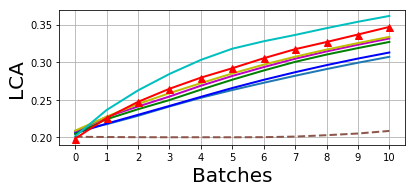

In [18]:
batches_we_care = np.arange(BATCHES_WE_CARE+1)
fig = plt.figure(figsize=(8, 2.5))
ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])

ax.plot(batches_we_care, np.mean(area_trapz['VAN'], axis=0),'C0', lw=2, label='VAN')
ax.plot(batches_we_care, np.mean(area_trapz['EWC'], axis=0),'-m', lw=2, label='EWC')
ax.plot(batches_we_care, np.mean(area_trapz['PI'], axis=0),'-b', lw=2, label='PI')
ax.plot(batches_we_care, np.mean(area_trapz['RWALK'], axis=0),'-g', lw=2, label='RWALK')
ax.plot(batches_we_care, np.mean(area_trapz['MAS'], axis=0),'-y', lw=2, label='MAS')
ax.plot(batches_we_care, np.mean(area_trapz['PROG-NN'], axis=0),'C5--', lw=2, label='PROG-NN')
ax.plot(batches_we_care, area_trapz['GEM'],'-c', lw=2, label='GEM')
ax.plot(batches_we_care, np.mean(area_trapz['A-GEM'], axis=0),'-r', marker='^', markersize=7, lw=2, label='A-GEM')

ax.set_xlabel('Batches', size=20)
ax.set_ylabel('LCA', size=20)
plt.xticks(batches_we_care)
plt.grid()
#plt.show()
plt.savefig('iclr_plots/fam_cifar.pdf')

# SPLIT CUB

In [6]:
# 10 runs
PREFIX = PREFIX = '/Users/arslanch/Dropbox/lll/final_results/cub/'
multi_task_ohot_pickle = '/Users/arslanch/Dropbox/lll/final_results/cub_5_runs/ohot/multi_task/SPLIT_CUB_ONE_HOT_HERDING_False_RESNET-B_False_True_VAN_0_0_03_10_False_5-18-10-26-03-52.pickle'
van_ohot_pickle = PREFIX+'ohot/SPLIT_CUB_ONE_HOT_HERDING_False_RESNET-B_False_True_VAN_0_0_03_10_False_5-18-11-09-12-31.pickle'
ewc_ohot_pickle = PREFIX+'ohot/SPLIT_CUB_ONE_HOT_HERDING_False_RESNET-B_False_True_EWC_1_0_03_10_False_5-18-11-09-17-35.pickle'
pi_ohot_pickle = PREFIX+'ohot/SPLIT_CUB_ONE_HOT_HERDING_False_RESNET-B_False_True_PI_0_1_0_03_10_False_5-18-11-10-07-28.pickle'
mas_ohot_pickle = PREFIX+'ohot/SPLIT_CUB_ONE_HOT_HERDING_False_RESNET-B_False_True_MAS_0_1_0_03_10_False_5-18-11-10-07-28.pickle'
rwalk_ohot_pickle = PREFIX+'ohot/SPLIT_CUB_ONE_HOT_HERDING_False_RESNET-B_False_True_RWALK_1_0_03_10_False_5-18-11-10-07-28.pickle'
a_gem_ohot_pickle = '/Users/arslanch/Dropbox/lll/average_results/cub/ohot/SPLIT_CUB_ONE_HOT_HERDING_False_RESNET-B_False_True_A-GEM_0_0_03_10_False_5-18-12-07-11-21.pickle'

multi_task_zst_pickle = '/Users/arslanch/Dropbox/lll/final_results/cub_5_runs/je/multi_task/SPLIT_CUB_HERDING_False_HYB_False_RESNET-B_False_True_VAN_0_10_False_5-18-10-26-03-52.pickle'
van_zst_pickle = PREFIX+'je/SPLIT_CUB_HERDING_False_HYB_False_RESNET-B_False_True_VAN_0_10_False_5-18-11-09-12-32.pickle'
ewc_zst_pickle = PREFIX+'je/SPLIT_CUB_HERDING_False_HYB_False_RESNET-B_False_True_EWC_10_10_False_5-18-11-09-17-30.pickle'
pi_zst_pickle = PREFIX+'je/SPLIT_CUB_HERDING_False_HYB_False_RESNET-B_False_True_PI_0_1_10_False_5-18-11-10-07-28.pickle'
mas_zst_pickle = PREFIX+'je/SPLIT_CUB_HERDING_False_HYB_False_RESNET-B_False_True_MAS_0_1_10_False_5-18-11-10-07-28.pickle'
rwalk_zst_pickle = PREFIX+'je/SPLIT_CUB_HERDING_False_HYB_False_RESNET-B_False_True_RWALK_1_10_False_5-18-11-10-07-28.pickle'
a_gem_zst_pickle = '/Users/arslanch/Dropbox/lll/average_results/cub/zst/SPLIT_CUB_HERDING_False_HYB_False_RESNET-B_False_True_A-GEM_0_10_False_5-18-12-07-13-15.pickle'
MODELS = ['VAN', 'EWC', 'PI', 'RWALK', 'MAS', 'A-GEM']

In [10]:
# Compute multi task performance separately
multi_task_ohot_mean = dict()
multi_task_zst_mean = dict()
populate_data_dict(multi_task_ohot_mean, 'MULTI-TASK', multi_task_ohot_pickle)
populate_data_dict(multi_task_zst_mean, 'MULTI-TASK', multi_task_zst_pickle)

# Print final average accuracies for all the methods
print('Average Acc for a simple classification model:')
for key in multi_task_ohot_mean:
    print('{}: {}'.format(key, np.mean(multi_task_ohot_mean[key]['mean'][-1, :])))
  
print('\n'*2)

print('Average Acc for joint embedding model:')
for key in multi_task_zst_mean:
    print('{}: {}'.format(key, np.mean(multi_task_zst_mean[key]['mean'][-1, :])))


Average Acc for a simple classification model:
MULTI-TASK: 0.656055258388



Average Acc for joint embedding model:
MULTI-TASK: 0.738573815469


In [7]:
# Dicts to store experiments data
data_ohot_mean = dict()
data_zst_mean = dict()
data_hybrid_mean = dict()

populate_data_dict(data_ohot_mean, 'VAN', van_ohot_pickle)
populate_data_dict(data_ohot_mean, 'EWC', ewc_ohot_pickle)
populate_data_dict(data_ohot_mean, 'PI', pi_ohot_pickle)
populate_data_dict(data_ohot_mean, 'RWALK', rwalk_ohot_pickle)
#populate_data_dict(data_ohot_mean, 'MAS', mas_ohot_pickle)
populate_data_dict(data_ohot_mean, 'A-GEM', a_gem_ohot_pickle)


populate_data_dict(data_zst_mean, 'VAN', van_zst_pickle)
populate_data_dict(data_zst_mean, 'EWC', ewc_zst_pickle)
populate_data_dict(data_zst_mean, 'PI', pi_zst_pickle)
populate_data_dict(data_zst_mean, 'RWALK', rwalk_zst_pickle)
#populate_data_dict(data_zst_mean, 'MAS', mas_zst_pickle)
populate_data_dict(data_zst_mean, 'A-GEM', a_gem_zst_pickle)


# Dicts to store the average k-shot acc
avg_k_shot_ohot_acc = dict()
avg_k_shot_zst_acc = dict()
avg_k_shot_hybrid_acc = dict()

populate_k_shot_acc_dict(data_ohot_mean, 'VAN', avg_k_shot_ohot_acc)
populate_k_shot_acc_dict(data_ohot_mean, 'EWC', avg_k_shot_ohot_acc)
populate_k_shot_acc_dict(data_ohot_mean, 'PI', avg_k_shot_ohot_acc)
populate_k_shot_acc_dict(data_ohot_mean, 'RWALK', avg_k_shot_ohot_acc)
#populate_k_shot_acc_dict(data_ohot_mean, 'MAS', avg_k_shot_ohot_acc)
populate_k_shot_acc_dict(data_ohot_mean, 'A-GEM', avg_k_shot_ohot_acc)

populate_k_shot_acc_dict(data_zst_mean, 'VAN', avg_k_shot_zst_acc)
populate_k_shot_acc_dict(data_zst_mean, 'EWC', avg_k_shot_zst_acc)
populate_k_shot_acc_dict(data_zst_mean, 'PI', avg_k_shot_zst_acc)
populate_k_shot_acc_dict(data_zst_mean, 'RWALK', avg_k_shot_zst_acc)
#populate_k_shot_acc_dict(data_zst_mean, 'MAS', avg_k_shot_zst_acc)
populate_k_shot_acc_dict(data_zst_mean, 'A-GEM', avg_k_shot_zst_acc)

In [8]:
for key in data_zst_mean:
    print(key, data_zst_mean[key]['mean'].shape)

('EWC', (10, 17, 15, 17))
('RWALK', (10, 17, 15, 17))
('PI', (10, 17, 15, 17))
('VAN', (10, 17, 15, 17))
('A-GEM', (10, 17, 15, 17))


### Average Accuracy and Forgetting

In [8]:
print('Average Acc forsimple classification models:')
for key in data_ohot_mean:
    acc_mean, acc_std = average_acc_stats_across_runs(data_ohot_mean[key]['mean'][:-1], key)
    fgt_mean, fgt_std, wst_fgt_mean, wst_fgt_std = average_fgt_stats_across_runs(data_ohot_mean[key]['mean'][:-1], key)
    print('{}=> Acc: {} (+-{}), Fgt: {} (+-{}), Wst Fgt: {} (+-{})'.format(key, acc_mean, 
                                                                            acc_std, fgt_mean, 
                                                                            fgt_std, wst_fgt_mean, 
                                                                            wst_fgt_std))
print('\n'*2)
        
print('Average Acc for JE models:')
for key in data_zst_mean:
    acc_mean, acc_std = average_acc_stats_across_runs(data_zst_mean[key]['mean'][:-1], key)
    fgt_mean, fgt_std, wst_fgt_mean, wst_fgt_std = average_fgt_stats_across_runs(data_zst_mean[key]['mean'][:-1], key)
    print('{}=> Acc: {} (+-{}), Fgt: {} (+-{}), Wst Fgt: {} (+-{})'.format(key, acc_mean, 
                                                                            acc_std, fgt_mean, 
                                                                            fgt_std, wst_fgt_mean, 
                                                                            wst_fgt_std))

Average Acc forsimple classification models:
EWC=> Acc: 54.0383709941 (+-1.08702053504), Fgt: 0.132471546012 (+-0.0229563441411), Wst Fgt: 0.274930613229 (+-0.0861888960763)
RWALK=> Acc: 54.4429957011 (+-1.82767602473), Fgt: 0.129373461133 (+-0.0180870247434), Wst Fgt: 0.29641197369 (+-0.0844494295898)
PI=> Acc: 55.3596834491 (+-2.28883521148), Fgt: 0.119567379821 (+-0.0208873739434), Wst Fgt: 0.256198332849 (+-0.0521375716153)
VAN=> Acc: 54.3767759914 (+-2.03096584902), Fgt: 0.129985026904 (+-0.0207751409608), Wst Fgt: 0.252382612037 (+-0.04239138859)
A-GEM=> Acc: 62.0151103585 (+-3.56718204888), Fgt: 0.0746361635102 (+-0.0265666696592), Wst Fgt: 0.185575314208 (+-0.0470958545382)



Average Acc for JE models:
EWC=> Acc: 68.4636614726 (+-4.08054982766), Fgt: 0.0908838463023 (+-0.0386812149149), Wst Fgt: 0.191094836298 (+-0.060574066797)
RWALK=> Acc: 67.4462182505 (+-3.50641623814), Fgt: 0.101297669801 (+-0.0398961542439), Wst Fgt: 0.213299815184 (+-0.0668772208559)
PI=> Acc: 66.692515

##### Zero-shot variation for all the tasks

In [9]:
zst_ohot, zst_je = get_zero_shot_perf(data_ohot_mean, data_zst_mean)

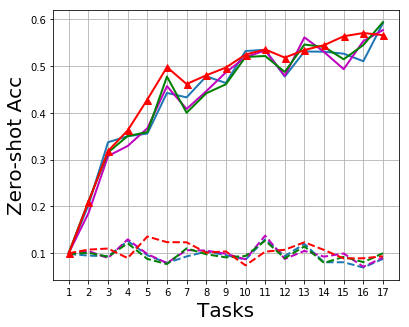

In [10]:
num_tasks = zst_ohot['VAN'].shape[0]
tasks = np.arange(1, num_tasks+1)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])

ax.plot(tasks, zst_ohot['VAN'],'C0--', lw=2, label='VAN')
ax.plot(tasks, zst_ohot['EWC'],'m--', lw=2, label='EWC')
ax.plot(tasks, zst_ohot['RWALK'],'g--', lw=2, label='RWALK')
ax.plot(tasks, zst_ohot['A-GEM'],'r--', markersize=7, lw=2, label='A-GEM')

ax.plot(tasks, zst_je['VAN'],'C0', lw=2, label='VAN-JE')
ax.plot(tasks, zst_je['EWC'],'-m', lw=2, label='EWC-JE')
ax.plot(tasks, zst_je['RWALK'],'-g', lw=2, label='RWALK-JE')
ax.plot(tasks, zst_je['A-GEM'],'-r', marker='^', markersize=7, lw=2, label='A-GEM-JE')


ax.set_xlabel('Tasks', size=20)
ax.set_ylabel('Zero-shot Acc', size=20)
plt.xticks(tasks)

#ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#ax.legend(loc='best', borderaxespad=0.2)
plt.grid()
#plt.show()
plt.savefig('iclr_plots/zst_perf_cub.pdf')

### LCA Measure

In [11]:
# Using trapezoidal rule
EXAMPLES_PER_TASK = 300
BATCH_SIZE = 10
num_iters = (EXAMPLES_PER_TASK + BATCH_SIZE - 1) // BATCH_SIZE
num_batches = []
for iters in range(num_iters):
    if (iters < 10) or (iters % 5 == 0):
        num_batches.append(iters)
num_batches.append(num_iters)
    
BATCHES_WE_CARE = 10

num_runs = avg_k_shot_ohot_acc['VAN'].shape[0]

area_ohot_trapz = dict()
area_zst_trapz = dict()

area_ohot_trapz['VAN'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_ohot_trapz['EWC'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_ohot_trapz['PI'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_ohot_trapz['RWALK'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
#area_ohot_trapz['MAS'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_ohot_trapz['A-GEM'] = np.zeros([num_runs,BATCHES_WE_CARE+1])

area_zst_trapz['VAN'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_zst_trapz['EWC'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_zst_trapz['PI'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_zst_trapz['RWALK'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
#area_zst_trapz['MAS'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_zst_trapz['A-GEM'] = np.zeros([num_runs,BATCHES_WE_CARE+1])

for run in range(num_runs):
    for measure_upto in range(1, BATCHES_WE_CARE+2):
        batches_upto = num_batches[:measure_upto]
        max_acc = np.ones_like(batches_upto)
        max_area_trapz = np.trapz(max_acc, batches_upto)
        if measure_upto == 1:
            area_ohot_trapz['VAN'][run][measure_upto-1] = avg_k_shot_ohot_acc['VAN'][run][0]
            area_ohot_trapz['EWC'][run][measure_upto-1] = avg_k_shot_ohot_acc['EWC'][run][0]
            area_ohot_trapz['PI'][run][measure_upto-1] = avg_k_shot_ohot_acc['PI'][run][0]
            #area_ohot_trapz['MAS'][run][measure_upto-1] = avg_k_shot_ohot_acc['MAS'][run][0]
            area_ohot_trapz['RWALK'][run][measure_upto-1] = avg_k_shot_ohot_acc['RWALK'][run][0]
            area_ohot_trapz['A-GEM'][run][measure_upto-1] = avg_k_shot_ohot_acc['A-GEM'][run][0]
    
            area_zst_trapz['VAN'][run][measure_upto-1] = avg_k_shot_zst_acc['VAN'][run][0]
            area_zst_trapz['EWC'][run][measure_upto-1] = avg_k_shot_zst_acc['EWC'][run][0]
            area_zst_trapz['PI'][run][measure_upto-1] = avg_k_shot_zst_acc['PI'][run][0]
            #area_zst_trapz['MAS'][run][measure_upto-1] = avg_k_shot_zst_acc['MAS'][run][0]
            area_zst_trapz['RWALK'][run][measure_upto-1] = avg_k_shot_zst_acc['RWALK'][run][0]
            area_zst_trapz['A-GEM'][run][measure_upto-1] = avg_k_shot_zst_acc['A-GEM'][run][0]
        else:
            area_ohot_trapz['VAN'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['VAN'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_ohot_trapz['PI'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['PI'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_ohot_trapz['RWALK'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['RWALK'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_ohot_trapz['EWC'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['EWC'][run][:measure_upto], batches_upto)/ max_area_trapz
            #area_ohot_trapz['MAS'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['MAS'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_ohot_trapz['A-GEM'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['A-GEM'][run][:measure_upto], batches_upto)/ max_area_trapz

            area_zst_trapz['VAN'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['VAN'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_zst_trapz['PI'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['PI'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_zst_trapz['RWALK'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['RWALK'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_zst_trapz['EWC'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['EWC'][run][:measure_upto], batches_upto)/ max_area_trapz
            #area_zst_trapz['MAS'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['MAS'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_zst_trapz['A-GEM'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['A-GEM'][run][:measure_upto], batches_upto)/ max_area_trapz

print('LCA_10 classification models:')
for key in area_ohot_trapz:
    lca_10 = area_ohot_trapz[key][:, 10]
    print('{}: {} (+-{})'.format(key, lca_10.mean(), lca_10.std()))
print('\n'*3)

print('LCA_10 JE models:')
for key in area_ohot_trapz:
    lca_10 = area_zst_trapz[key][:, 10]
    print('{}: {} (+-{})'.format(key, lca_10.mean(), lca_10.std()))


LCA_10 classification models:
EWC: 0.291610035449 (+-0.0072219991408)
RWALK: 0.292043889165 (+-0.00854600012842)
PI: 0.292813697308 (+-0.00861164850019)
VAN: 0.291908545643 (+-0.00912678869179)
A-GEM: 0.300193669349 (+-0.00882976664276)




LCA_10 JE models:
EWC: 0.516303309202 (+-0.0161306135306)
RWALK: 0.52062433362 (+-0.0189040634186)
PI: 0.516667436063 (+-0.015957480642)
VAN: 0.51900600791 (+-0.0186290566297)
A-GEM: 0.543653441072 (+-0.0214466505403)


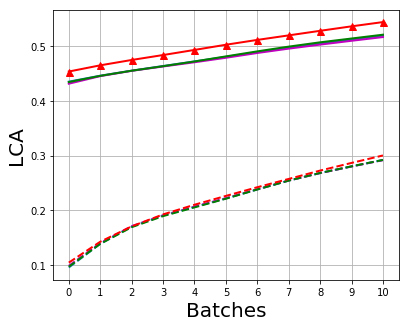

In [12]:
batches_we_care = np.arange(BATCHES_WE_CARE+1)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])

ax.plot(batches_we_care, np.mean(area_ohot_trapz['VAN'], axis=0),'C0--', lw=2, label='VAN')
ax.plot(batches_we_care, np.mean(area_ohot_trapz['EWC'], axis=0),'m--', lw=2, label='EWC')
ax.plot(batches_we_care, np.mean(area_ohot_trapz['RWALK'], axis=0),'g--', lw=2, label='RWALK')
ax.plot(batches_we_care, np.mean(area_ohot_trapz['A-GEM'], axis=0),'r--', markersize=7, lw=2, label='A-GEM')

ax.plot(batches_we_care, np.mean(area_zst_trapz['VAN'], axis=0),'C0', lw=2, label='VAN-JE')
ax.plot(batches_we_care, np.mean(area_zst_trapz['EWC'], axis=0),'-m', lw=2, label='EWC-JE')
ax.plot(batches_we_care, np.mean(area_zst_trapz['RWALK'], axis=0),'-g', lw=2, label='RWALK-JE')
ax.plot(batches_we_care, np.mean(area_zst_trapz['A-GEM'], axis=0),'-r', marker='^', markersize=7, lw=2, label='A-GEM-JE')


ax.set_xlabel('Batches', size=20)
ax.set_ylabel('LCA', size=20)
plt.xticks(batches_we_care)

plt.grid()
#plt.show()
plt.savefig('iclr_plots/fam_cub.pdf')

# SPLIT AWA

In [6]:
# 20 Tasks, 10 runs
PREFIX = '/Users/arslanch/Dropbox/lll/final_results/awa/'
van_ohot_pickle = PREFIX + 'ohot/SPLIT_AWA_ONE_HOT_HERDING_False_RESNET-B_False_True_VAN_0_0_001_10_False_20-18-11-09-12-43.pickle'
ewc_ohot_pickle = PREFIX + 'ohot/SPLIT_AWA_ONE_HOT_HERDING_False_RESNET-B_False_True_EWC_100_0_003_10_False_20-18-11-09-12-43.pickle'
pi_ohot_pickle = PREFIX + 'ohot/SPLIT_AWA_ONE_HOT_HERDING_False_RESNET-B_False_True_PI_1_0_003_10_False_20-18-11-09-12-37.pickle'
rwalk_ohot_pickle = PREFIX + 'ohot/SPLIT_AWA_ONE_HOT_HERDING_False_RESNET-B_False_True_RWALK_10_0_003_10_False_20-18-11-09-12-38.pickle'
a_gem_ohot_pickle = '/Users/arslanch/Dropbox/lll/average_results/awa/ohot/SPLIT_AWA_ONE_HOT_HERDING_False_RESNET-B_False_True_A-GEM_0_0_01_10_False_20-18-12-07-10-32.pickle'

van_zst_pickle = PREFIX + 'je/SPLIT_AWA_HERDING_False_HYB_False_RESNET-B_False_True_VAN_0_10_False_20-18-11-09-12-43.pickle'
ewc_zst_pickle = PREFIX + 'je/SPLIT_AWA_HERDING_False_HYB_False_RESNET-B_False_True_EWC_100_10_False_20-18-11-09-12-37.pickle'
pi_zst_pickle = PREFIX + 'je/SPLIT_AWA_HERDING_False_HYB_False_RESNET-B_False_True_PI_10_10_False_20-18-11-09-12-37.pickle'
rwalk_zst_pickle = PREFIX + 'je/SPLIT_AWA_HERDING_False_HYB_False_RESNET-B_False_True_RWALK_10_10_False_20-18-11-09-12-39.pickle'
a_gem_zst_pickle = '/Users/arslanch/Dropbox/lll/average_results/awa/zst/SPLIT_AWA_HERDING_False_HYB_False_RESNET-B_False_True_A-GEM_0_10_False_20-18-12-08-07-56.pickle'
MODELS = ['VAN', 'EWC', 'PI', 'RWALK', 'MAS', 'A-GEM']

In [7]:
# Dicts to store experiments data
data_ohot_mean = dict()
data_zst_mean = dict()

populate_data_dict(data_ohot_mean, 'VAN', van_ohot_pickle)
populate_data_dict(data_ohot_mean, 'EWC', ewc_ohot_pickle)
populate_data_dict(data_ohot_mean, 'PI', pi_ohot_pickle)
populate_data_dict(data_ohot_mean, 'RWALK', rwalk_ohot_pickle)
populate_data_dict(data_ohot_mean, 'A-GEM', a_gem_ohot_pickle)


populate_data_dict(data_zst_mean, 'VAN', van_zst_pickle)
populate_data_dict(data_zst_mean, 'EWC', ewc_zst_pickle)
populate_data_dict(data_zst_mean, 'PI', pi_zst_pickle)
populate_data_dict(data_zst_mean, 'RWALK', rwalk_zst_pickle)
populate_data_dict(data_zst_mean, 'A-GEM', a_gem_zst_pickle)


# Dicts to store the average k-shot acc
avg_k_shot_ohot_acc = dict()
avg_k_shot_zst_acc = dict()
batches_per_task_ohot = dict()
batches_per_task_zst = dict()

batches_per_task_ohot['VAN'] = populate_k_shot_acc_dict_with_varying_batches(data_ohot_mean, 'VAN', avg_k_shot_ohot_acc)
batches_per_task_ohot['EWC'] = populate_k_shot_acc_dict_with_varying_batches(data_ohot_mean, 'EWC', avg_k_shot_ohot_acc)
batches_per_task_ohot['PI'] = populate_k_shot_acc_dict_with_varying_batches(data_ohot_mean, 'PI', avg_k_shot_ohot_acc)
batches_per_task_ohot['RWALK'] = populate_k_shot_acc_dict_with_varying_batches(data_ohot_mean, 'RWALK', avg_k_shot_ohot_acc)
batches_per_task_ohot['A-GEM'] = populate_k_shot_acc_dict_with_varying_batches(data_ohot_mean, 'A-GEM', avg_k_shot_ohot_acc)

batches_per_task_zst['VAN'] = populate_k_shot_acc_dict_with_varying_batches(data_zst_mean, 'VAN', avg_k_shot_zst_acc)
batches_per_task_zst['EWC'] = populate_k_shot_acc_dict_with_varying_batches(data_zst_mean, 'EWC', avg_k_shot_zst_acc)
batches_per_task_zst['PI'] = populate_k_shot_acc_dict_with_varying_batches(data_zst_mean, 'PI', avg_k_shot_zst_acc)
batches_per_task_zst['RWALK'] = populate_k_shot_acc_dict_with_varying_batches(data_zst_mean, 'RWALK', avg_k_shot_zst_acc)
batches_per_task_zst['A-GEM'] = populate_k_shot_acc_dict_with_varying_batches(data_zst_mean, 'A-GEM', avg_k_shot_zst_acc)


batches_per_task = batches_per_task_ohot['VAN']

### Average Accuracy and Forgetting

In [8]:
print('Average Acc for simple classification models:')
for key in data_ohot_mean:
    acc_mean, acc_std = average_acc_stats_across_runs(data_ohot_mean[key]['mean'][:,:,:batches_per_task_ohot[key][-1],:], key)
    fgt_mean, fgt_std, wst_fgt_mean, wst_fgt_std = average_fgt_stats_across_runs(data_ohot_mean[key]['mean'][:,:,:batches_per_task_ohot[key][-1],:], key)
    print('{}=> Acc: {} (+-{}), Fgt: {} (+-{}), Wst Fgt: {} (+-{})'.format(key, acc_mean, 
                                                                            acc_std, fgt_mean, 
                                                                            fgt_std, wst_fgt_mean, 
                                                                            wst_fgt_std))
print('\n'*2)
        
print('Average Acc for JE models:')
for key in data_zst_mean:
    acc_mean, acc_std = average_acc_stats_across_runs(data_zst_mean[key]['mean'][:,:,:batches_per_task_zst[key][-1],:], key)
    fgt_mean, fgt_std, wst_fgt_mean, wst_fgt_std = average_fgt_stats_across_runs(data_zst_mean[key]['mean'][:,:,:batches_per_task_zst[key][-1],:], key)
    print('{}=> Acc: {} (+-{}), Fgt: {} (+-{}), Wst Fgt: {} (+-{})'.format(key, acc_mean, 
                                                                            acc_std, fgt_mean, 
                                                                            fgt_std, wst_fgt_mean, 
                                                                            wst_fgt_std))

Average Acc for simple classification models:
EWC=> Acc: 33.9192474671 (+-2.872543645), Fgt: 0.0778124573259 (+-0.0220059937295), Wst Fgt: 0.216440567915 (+-0.0474679304441)
RWALK=> Acc: 33.9572258099 (+-2.91033884013), Fgt: 0.0784394271977 (+-0.0212668650914), Wst Fgt: 0.218322353367 (+-0.0409738037999)
PI=> Acc: 33.955779056 (+-3.25670370955), Fgt: 0.0786552376762 (+-0.0229268672223), Wst Fgt: 0.215240928132 (+-0.046438075562)
VAN=> Acc: 30.3456107599 (+-2.84422446449), Fgt: 0.0360189683738 (+-0.0147440045793), Wst Fgt: 0.127124472028 (+-0.0564629948043)
A-GEM=> Acc: 43.9612528822 (+-4.1028764775), Fgt: 0.0567665161185 (+-0.0287133547031), Wst Fgt: 0.160566314593 (+-0.0661463833688)



Average Acc for JE models:
EWC=> Acc: 43.3011496636 (+-3.71274312692), Fgt: 0.0664503212007 (+-0.0310801193292), Wst Fgt: 0.163898580032 (+-0.0465492071377)
RWALK=> Acc: 42.9334446271 (+-3.10334397722), Fgt: 0.0689625010777 (+-0.02897205626), Wst Fgt: 0.184072228779 (+-0.0379902363784)
PI=> Acc: 43.429

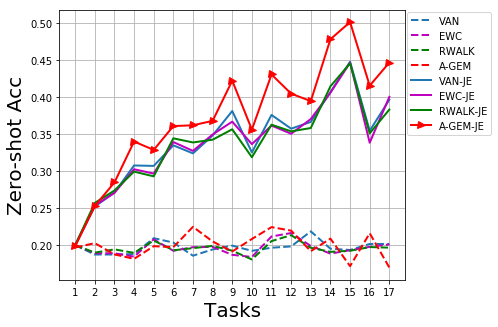

In [9]:
zst_ohot, zst_je = get_zero_shot_perf(data_ohot_mean, data_zst_mean)
num_tasks = zst_ohot['VAN'].shape[0]
tasks = np.arange(1, num_tasks+1)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])

ax.plot(tasks, zst_ohot['VAN'],'C0--', lw=2, label='VAN')
ax.plot(tasks, zst_ohot['EWC'],'m--', lw=2, label='EWC')
ax.plot(tasks, zst_ohot['RWALK'],'g--', lw=2, label='RWALK')
ax.plot(tasks, zst_ohot['A-GEM'],'r--', markersize=7, lw=2, label='A-GEM')


ax.plot(tasks, zst_je['VAN'],'C0', lw=2, label='VAN-JE')
ax.plot(tasks, zst_je['EWC'],'-m', lw=2, label='EWC-JE')
ax.plot(tasks, zst_je['RWALK'],'-g', lw=2, label='RWALK-JE')
ax.plot(tasks, zst_je['A-GEM'],'-r', marker='>', markersize=7, lw=2, label='A-GEM-JE')


ax.set_xlabel('Tasks', size=20)
ax.set_ylabel('Zero-shot Acc', size=20)
plt.xticks(tasks)

ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
plt.grid()
#plt.show()
plt.savefig('iclr_plots/zst_perf_awa_20tasks.pdf')

### LCA Measure

In [10]:
# Using trapezoidal rule
f = open('/Users/arslanch/Dropbox/AWA_train_list.txt', 'rb').readlines()
NUM_CLASSES = 50
NUM_TASKS = 10
BATCH_SIZE = 10
examples_per_task = np.zeros([NUM_TASKS], dtype=np.int32)
for line in f:
    img, label = line.split()
    label = int(label)
    examples_per_task[label//(NUM_CLASSES/ NUM_TASKS)] += 1
    
num_batches = []
for task in examples_per_task:
    num_batches_per_task = []
    num_iters = (task + BATCH_SIZE - 1)// BATCH_SIZE
    for iters in range(num_iters):
        if (iters < 20) or (iters % 50 == 0):
            num_batches_per_task.append(iters)
    num_batches_per_task.append(iters)
    if (len(num_batches_per_task) > len(num_batches)):
        num_batches = num_batches_per_task
        
num_runs = avg_k_shot_ohot_acc['VAN'].shape[0]

BATCHES_WE_CARE = 10

area_ohot_trapz = dict()
area_zst_trapz = dict()

area_ohot_trapz['VAN'] = np.zeros([num_runs, BATCHES_WE_CARE+1])
area_ohot_trapz['EWC'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_ohot_trapz['PI'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_ohot_trapz['RWALK'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_ohot_trapz['A-GEM'] = np.zeros([num_runs,BATCHES_WE_CARE+1])

area_zst_trapz['VAN'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_zst_trapz['EWC'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_zst_trapz['PI'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_zst_trapz['RWALK'] = np.zeros([num_runs,BATCHES_WE_CARE+1])
area_zst_trapz['A-GEM'] = np.zeros([num_runs,BATCHES_WE_CARE+1])

for run in range(num_runs):
    for measure_upto in range(1, BATCHES_WE_CARE+2):
        batches_upto = num_batches[:measure_upto]
        max_acc = np.ones_like(batches_upto)
        max_area_trapz = np.trapz(max_acc, batches_upto)
        if measure_upto == 1:
            area_ohot_trapz['VAN'][run][measure_upto-1] = avg_k_shot_ohot_acc['VAN'][run][0]
            area_ohot_trapz['EWC'][run][measure_upto-1] = avg_k_shot_ohot_acc['EWC'][run][0]
            area_ohot_trapz['PI'][run][measure_upto-1] = avg_k_shot_ohot_acc['PI'][run][0]
            area_ohot_trapz['RWALK'][run][measure_upto-1] = avg_k_shot_ohot_acc['RWALK'][run][0]
            area_ohot_trapz['A-GEM'][run][measure_upto-1] = avg_k_shot_ohot_acc['A-GEM'][run][0]
    
            area_zst_trapz['VAN'][run][measure_upto-1] = avg_k_shot_zst_acc['VAN'][run][0]
            area_zst_trapz['EWC'][run][measure_upto-1] = avg_k_shot_zst_acc['EWC'][run][0]
            area_zst_trapz['PI'][run][measure_upto-1] = avg_k_shot_zst_acc['PI'][run][0]
            area_zst_trapz['RWALK'][run][measure_upto-1] = avg_k_shot_zst_acc['RWALK'][run][0]
            area_zst_trapz['A-GEM'][run][measure_upto-1] = avg_k_shot_zst_acc['A-GEM'][run][0]
        else:
            area_ohot_trapz['VAN'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['VAN'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_ohot_trapz['PI'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['PI'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_ohot_trapz['RWALK'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['RWALK'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_ohot_trapz['EWC'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['EWC'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_ohot_trapz['A-GEM'][run][measure_upto-1] = np.trapz(avg_k_shot_ohot_acc['A-GEM'][run][:measure_upto], batches_upto)/ max_area_trapz

            area_zst_trapz['VAN'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['VAN'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_zst_trapz['PI'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['PI'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_zst_trapz['RWALK'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['RWALK'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_zst_trapz['EWC'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['EWC'][run][:measure_upto], batches_upto)/ max_area_trapz
            area_zst_trapz['A-GEM'][run][measure_upto-1] = np.trapz(avg_k_shot_zst_acc['A-GEM'][run][:measure_upto], batches_upto)/ max_area_trapz

print('LCA_10 classification models:')
for key in area_ohot_trapz:
    lca_10 = area_ohot_trapz[key][:, 10]
    print('{}: {} (+-{})'.format(key, lca_10.mean(), lca_10.std()))
print('\n'*3)

print('LCA_10 JE models:')
for key in area_ohot_trapz:
    lca_10 = area_zst_trapz[key][:, 10]
    print('{}: {} (+-{})'.format(key, lca_10.mean(), lca_10.std()))


LCA_10 classification models:
EWC: 0.257335433066 (+-0.0105906421955)
RWALK: 0.256686180234 (+-0.0107795228564)
PI: 0.257917417586 (+-0.0112127729784)
VAN: 0.214348887354 (+-0.00819702224496)
A-GEM: 0.287455254644 (+-0.0119579338382)




LCA_10 JE models:
EWC: 0.368725480437 (+-0.021241108008)
RWALK: 0.368047055304 (+-0.0218804312246)
PI: 0.367534119189 (+-0.0213335677524)
VAN: 0.367851422727 (+-0.0215095329973)
A-GEM: 0.392380404174 (+-0.0230852430967)


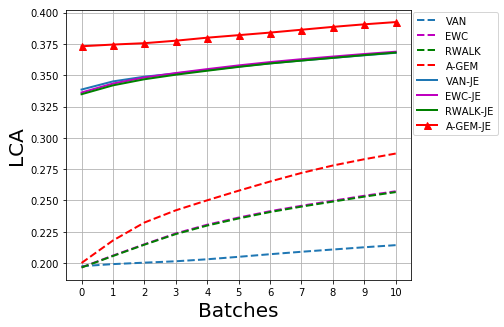

In [11]:
batches_we_care = np.arange(BATCHES_WE_CARE+1)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.15, 0.21, 0.6, 0.75])

ax.plot(batches_we_care, np.mean(area_ohot_trapz['VAN'], axis=0),'C0--', lw=2, label='VAN')
ax.plot(batches_we_care, np.mean(area_ohot_trapz['EWC'], axis=0),'m--', lw=2, label='EWC')
ax.plot(batches_we_care, np.mean(area_ohot_trapz['RWALK'], axis=0),'g--', lw=2, label='RWALK')
ax.plot(batches_we_care, np.mean(area_ohot_trapz['A-GEM'], axis=0),'r--', markersize=7, lw=2, label='A-GEM')

ax.plot(batches_we_care, np.mean(area_zst_trapz['VAN'], axis=0),'C0', lw=2, label='VAN-JE')
ax.plot(batches_we_care, np.mean(area_zst_trapz['EWC'], axis=0),'-m', lw=2, label='EWC-JE')
ax.plot(batches_we_care, np.mean(area_zst_trapz['RWALK'], axis=0),'-g', lw=2, label='RWALK-JE')
ax.plot(batches_we_care, np.mean(area_zst_trapz['A-GEM'], axis=0),'-r', marker='^', markersize=7, lw=2, label='A-GEM-JE')


ax.set_xlabel('Batches', size=20)
ax.set_ylabel('LCA', size=20)
plt.xticks(batches_we_care)

ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
plt.grid()
#plt.show()
plt.savefig('iclr_plots/fam_awa_20.pdf')

## Increasing epochs and architecture

In [52]:
mnist_acc_small_arch = dict()
mnist_fgt_small_arch = dict()
mnist_acc_big_arch = dict()
mnist_fgt_big_arch = dict()

cifar_acc_small_arch = dict()
cifar_fgt_small_arch = dict()
cifar_acc_big_arch = dict()
cifar_fgt_big_arch = dict()

epochs = [1, 3, 10, 30]
mnist_acc_small_arch['VAN'] = [0.506, 0.506, 0.496, 0.44]
mnist_acc_small_arch['EWC'] = [0.673, 0.592, 0.564, 0.52]
mnist_acc_small_arch['MAS'] = [0.708, 0.65, 0.541, 0]


mnist_fgt_small_arch['VAN'] = [0.48, 0.49, 0.49, 0.563]
mnist_fgt_small_arch['EWC'] = [0.30, 0.39, 0.435, 0.478]
mnist_fgt_small_arch['MAS'] = [0.26, 0.32, 0.445, 0]

mnist_acc_big_arch['VAN'] = [0.70, 0.75, 0.637, 0.75]
mnist_acc_big_arch['EWC'] = [0.75, 0.784, 0.836, 0.83]
mnist_acc_big_arch['MAS'] = [0.87, 0.90, 0.91, 0.87]

mnist_fgt_big_arch['VAN'] = [0.28, 0.236, 0.348, 0.245]
mnist_fgt_big_arch['EWC'] = [0.23, 0.20, 0.15, 0.16]
mnist_fgt_big_arch['MAS'] = [0.08, 0.06, 0.07, 0.11]

cifar_acc_small_arch['VAN'] = [0.45, 0.31, 0.36, 0.35]
cifar_acc_small_arch['EWC'] = [0.437, 0.34, 0.45, 0.47]
cifar_acc_small_arch['MAS'] = [0.448, 0.56, 0.586, 0.60]

cifar_fgt_small_arch['VAN'] = [0.23, 0.44, 0.46, 0.47]
cifar_fgt_small_arch['EWC'] = [0.25, 0.38, 0.23, 0.22]
cifar_fgt_small_arch['MAS'] = [0.23, 0.12, 0.09, 0.06]

cifar_acc_big_arch['VAN'] = [0.52, 0.48, 0.48, 0.50]
cifar_acc_big_arch['EWC'] = [0.44, 0.48, 0.55, 0.63]
cifar_acc_big_arch['MAS'] = [0.47, 0.53, 0.57, 0.58]

cifar_fgt_big_arch['VAN'] = [0.206, 0.29, 0.326, 0.313]
cifar_fgt_big_arch['EWC'] = [0.26, 0.23, 0.17, 0.08]
cifar_fgt_big_arch['MAS'] = [0.24, 0.14, 0.08, 0.06]



## MNIST

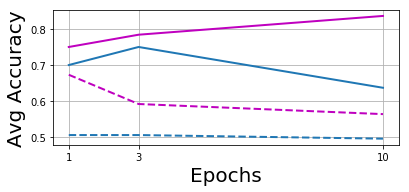

In [74]:
fig = plt.figure(figsize=(8,2.5))
ax = fig.add_axes([0.15, 0.23, 0.6, 0.75])
upto = -1
ax.plot(epochs[:upto], mnist_acc_small_arch['VAN'][:upto],'C0--', lw=2, label='VAN-S')
ax.plot(epochs[:upto], mnist_acc_small_arch['EWC'][:upto],'m--', lw=2, label='EWC-S')
#ax.plot(epochs, mnist_acc_small_arch['MAS'],'-b', lw=2, label='MAS-S')

ax.plot(epochs[:upto], mnist_acc_big_arch['VAN'][:upto],'C0', lw=2, label='VAN-B')
ax.plot(epochs[:upto], mnist_acc_big_arch['EWC'][:upto],'-m', lw=2, label='EWC-B')
#ax.plot(epochs, mnist_acc_big_arch['MAS'],'-m', lw=2, label='MAS-B')

plt.grid()
ax.set_xlabel('Epochs', size=20)
ax.set_ylabel('Avg Accuracy', size=20)
plt.xticks(epochs[:upto])
#ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#plt.show()
plt.savefig('iclr_plots/mnist_increasing_epochs_and_arch_acc.pdf')

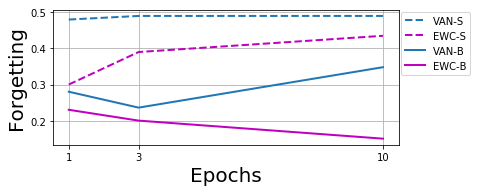

In [68]:
fig = plt.figure(figsize=(8,2.5))
ax = fig.add_axes([0.15, 0.23, 0.6, 0.75])
upto = -1

ax.plot(epochs[:upto], mnist_fgt_small_arch['VAN'][:upto],'C0--', lw=2, label='VAN-S')
ax.plot(epochs[:upto], mnist_fgt_small_arch['EWC'][:upto],'m--', lw=2, label='EWC-S')
#ax.plot(epochs, mnist_fgt_small_arch['MAS'],'-b', lw=2, label='MAS-S')

ax.plot(epochs[:upto], mnist_fgt_big_arch['VAN'][:upto],'C0', lw=2, label='VAN-B')
ax.plot(epochs[:upto], mnist_fgt_big_arch['EWC'][:upto],'-m', lw=2, label='EWC-B')
#ax.plot(epochs, mnist_fgt_big_arch['MAS'],'-m', lw=2, label='MAS-B')

plt.grid()
ax.set_xlabel('Epochs', size=20)
ax.set_ylabel('Forgetting', size=20)
plt.xticks(epochs[:upto])
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#plt.show()
plt.savefig('iclr_plots/mnist_increasing_epochs_and_arch_fgt.pdf')

## CIFAR

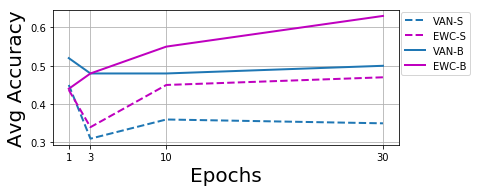

In [80]:
fig = plt.figure(figsize=(8,2.5))
ax = fig.add_axes([0.15, 0.23, 0.6, 0.75])
    
ax.plot(epochs, cifar_acc_small_arch['VAN'],'C0--', lw=2, label='VAN-S')
ax.plot(epochs, cifar_acc_small_arch['EWC'],'m--', lw=2, label='EWC-S')
#ax.plot(epochs, cifar_acc_small_arch['MAS'],'-b', lw=2, label='MAS-S')

ax.plot(epochs, cifar_acc_big_arch['VAN'],'C0', lw=2, label='VAN-B')
ax.plot(epochs, cifar_acc_big_arch['EWC'],'-m', lw=2, label='EWC-B')
#ax.plot(epochs, cifar_acc_big_arch['MAS'],'-m', lw=2, label='MAS-B')

plt.grid()
ax.set_xlabel('Epochs', size=20)
ax.set_ylabel('Avg Accuracy', size=20)
plt.xticks(epochs)
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#plt.show()
plt.savefig('iclr_plots/cifar_increasing_epochs_and_arch_acc.pdf')

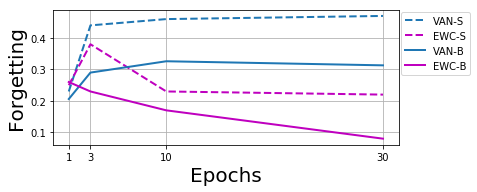

In [70]:
fig = plt.figure(figsize=(8,2.5))
ax = fig.add_axes([0.15, 0.23, 0.6, 0.75])

ax.plot(epochs, cifar_fgt_small_arch['VAN'],'C0--', lw=2, label='VAN-S')
ax.plot(epochs, cifar_fgt_small_arch['EWC'],'m--', lw=2, label='EWC-S')

ax.plot(epochs, cifar_fgt_big_arch['VAN'],'C0', lw=2, label='VAN-B')
ax.plot(epochs, cifar_fgt_big_arch['EWC'],'-m', lw=2, label='EWC-B')

plt.grid()
ax.set_xlabel('Epochs', size=20)
ax.set_ylabel('Forgetting', size=20)
plt.xticks(epochs)
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#plt.show()
plt.savefig('iclr_plots/cifar_increasing_epochs_and_arch_fgt.pdf')

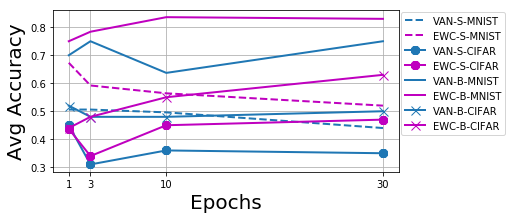

In [76]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_axes([0.15, 0.23, 0.6, 0.75])
    
ax.plot(epochs, mnist_acc_small_arch['VAN'],'C0--', lw=2, label='VAN-S-MNIST')
ax.plot(epochs, mnist_acc_small_arch['EWC'],'m--', lw=2, label='EWC-S-MNIST')
ax.plot(epochs, cifar_acc_small_arch['VAN'],'C0', marker='8', markersize=9, lw=2, label='VAN-S-CIFAR')
ax.plot(epochs, cifar_acc_small_arch['EWC'],'m', marker='8', markersize=9, lw=2, label='EWC-S-CIFAR')


ax.plot(epochs, mnist_acc_big_arch['VAN'],'C0', lw=2, label='VAN-B-MNIST')
ax.plot(epochs, mnist_acc_big_arch['EWC'],'-m', lw=2, label='EWC-B-MNIST')
ax.plot(epochs, cifar_acc_big_arch['VAN'],'C0', marker='x', markersize=9, lw=2, label='VAN-B-CIFAR')
ax.plot(epochs, cifar_acc_big_arch['EWC'],'m', marker='x', markersize=9, lw=2, label='EWC-B-CIFAR')

plt.grid()
ax.set_xlabel('Epochs', size=20)
ax.set_ylabel('Avg Accuracy', size=20)
plt.xticks(epochs)
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#plt.show()
plt.savefig('iclr_plots/increasing_epochs_and_arch_acc.pdf')

## GEM vs A-GEM Ablation

In [77]:
# Plot the constraint violations against the number of tasks
gem_mnist = np.array([0, 1038, 1664, 2088, 2614, 2993, 3209, 3704, 3977, 4243, 4602, 4684,
                      4765, 4847, 5032, 4749, 5096])
gem_cifar = np.array([0, 66, 97, 117, 121, 155, 171, 177, 188, 192, 197, 209, 215, 213, 222, 230, 233])

s_gem_mnist = np.array([0, 1105, 1316, 1412, 1465, 1476, 1545, 1593, 1703, 1701, 1733, 1881, 1710, 
                        1795, 1769, 1914, 1924])
s_gem_cifar = np.array([0, 82, 90, 83, 84, 83, 78, 103, 92, 97, 93, 75, 82, 82, 87, 94, 59])
tasks = np.arange(1,18)

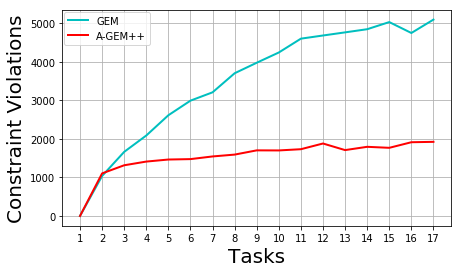

In [78]:
# MNIST Plot
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.15, 0.15, 0.6, 0.75])

ax.plot(tasks, gem_mnist,'-c', lw=2, label='GEM')
ax.plot(tasks, s_gem_mnist, '-r', lw=2, label='A-GEM++')


ax.set_xlabel('Tasks', size=20)
ax.set_ylabel('Constraint Violations', size=20)
plt.xticks(tasks)
#ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.legend(loc='best', borderaxespad=0.2)
plt.grid()
#plt.show()
plt.savefig('iclr_plots/gem_sgem_constraint_violations_mnist.pdf')

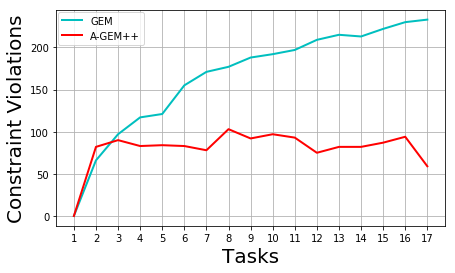

In [79]:
# CIFAR Plot
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.15, 0.15, 0.6, 0.75])

ax.plot(tasks, gem_cifar,'-c', lw=2, label='GEM')
ax.plot(tasks, s_gem_cifar, '-r', lw=2, label='A-GEM++')


ax.set_xlabel('Tasks', size=20)
ax.set_ylabel('Constraint Violations', size=20)
plt.xticks(tasks)
#ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.legend(loc='best', borderaxespad=0.2)
plt.grid()
#plt.show()
plt.savefig('iclr_plots/gem_sgem_constraint_violations_cifar.pdf')

## Average Accuracy and Worst-case forgetting on EPS Memory

In [81]:
data_cifar = dict()
data_mnist = dict()

a_gem_mnist_pickle = '/Users/arslanch/Dropbox/LLL_experiments/Single_Epoch/final_results/mnist/fc_small/1_epoch/epsmem_fgt_wst/PERMUTE_MNIST_HERDING_False_FC-S_False_True_S-GEM_0_0_10_False_25-18-09-17-16-20.pickle'
a_gem_cifar_pickle = '/Users/arslanch/Dropbox/LLL_experiments/Single_Epoch/final_results/cifar/resnet_small/1_epoch/epsmem_fgt_wst/SPLIT_CIFAR_HERDING_False_RESNET-S_False_True_S-GEM_0_0_0_03_10_False_13-18-09-17-16-20.pickle'

gem_mnist_pickle = '/Users/arslanch/Dropbox/LLL_experiments/Single_Epoch/final_results/mnist/fc_small/1_epoch/epsmem_fgt_wst/gem_permute_mnist_eps_mem.pickle'
gem_cifar_pickle = '/Users/arslanch/Dropbox/LLL_experiments/Single_Epoch/final_results/cifar/resnet_small/1_epoch/epsmem_fgt_wst/gem_split_cifar_eps_mem.pickle'


with open(a_gem_mnist_pickle, 'r') as f:
    data_mnist['A-GEM'] = pickle.load(f)['mean']

with open(a_gem_cifar_pickle, 'r') as f:
    data_cifar['A-GEM'] = pickle.load(f)['mean']

with open(gem_mnist_pickle, 'r') as f:
    data_mnist['GEM'] = pickle.load(f)

with open(gem_cifar_pickle, 'r') as f:
    data_cifar['GEM'] = pickle.load(f)


In [82]:
# Avg accuracy
for key in data_cifar:
    print('MNIST=> key {}: Avg_Acc: {}'.format(key, np.mean(data_mnist[key][-1])))
    print('CIFAR=> key {}: Avg_Acc: {}'.format(key, np.mean(data_cifar[key][-1])))
    print('\n'*2)

MNIST=> key GEM: Avg_Acc: 0.995905
CIFAR=> key GEM: Avg_Acc: 0.97152



MNIST=> key A-GEM: Avg_Acc: 0.993411779404
CIFAR=> key A-GEM: Avg_Acc: 0.720362007618





In [83]:
def compute_wst_fgt(data):
    """
    Given a TxT data matrix, compute average forgetting at T-th task
    """
    num_tasks = data.shape[0]
    T = num_tasks - 1
    fgt = np.zeros(T)
    for i in range(T):
        fgt[i] = np.max(data[:T,i]) - data[T, i]

    return (fgt.max())

In [84]:
# F_{wst}
for key in data_cifar:
    print('MNIST=> key {}: Fgt_wst: {}'.format(key, compute_wst_fgt(data_mnist[key])))
    print('CIFAR=> key {}: Fgt_wst: {}'.format(key, compute_wst_fgt(data_cifar[key])))
    print('\n'*2)

MNIST=> key GEM: Fgt_wst: 0.0
CIFAR=> key GEM: Fgt_wst: 0.0461



MNIST=> key A-GEM: Fgt_wst: 0.00800001621246
CIFAR=> key A-GEM: Fgt_wst: 0.153846144676





## Bar Plots

In [7]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

<Figure size 432x288 with 0 Axes>

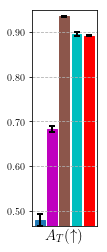

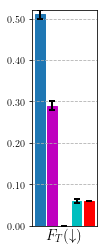

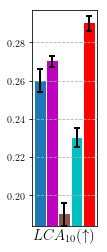

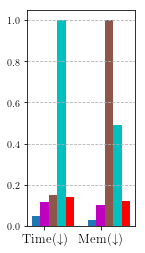

In [13]:
# MNIST
# metadata method = [Avg_Acc, Forgetting, LCA_10, Time, Mem]
plt.clf()
metric_name = ['acc', 'fgt', 'lca10', 'time', 'memory']
ticks = ['$A_T$($\uparrow$)', '$F_T$($\downarrow$)', '$LCA_{10}$($\uparrow$)', 'Time($\downarrow$)', 
         'Mem($\downarrow$)']
labels = ['VAN', 'EWC', 'PROG-NN', 'GEM', 'A-GEM']
colors = ['C0', 'm', 'C5', 'c', 'r']
bar_data = dict()
bar_error = dict()
bar_data['VAN'] = np.array([0.479, 0.51, 0.26, 0.05, 0.03])
bar_data['EWC'] = np.array([0.683, 0.29, 0.27, 0.117, 0.1])
bar_data['PROG-NN'] = np.array([0.935, 0, 0.19, 0.15, 1])
bar_data['GEM'] = np.array([0.895, 0.06, 0.23, 1, 0.49])
bar_data['A-GEM'] = np.array([0.891, 0.06, 0.29, 0.138, 0.12])

bar_error['VAN'] = np.array([0.0132, 0.01, 0.006, 0, 0])
bar_error['EWC'] = np.array([0.0069, 0.01, 0.003, 0, 0])
bar_error['PROG-NN'] = np.array([0.0007, 0, 0.006, 0, 0])
bar_error['GEM'] = np.array([0.0048, 0.004, 0.005, 0, 0])
bar_error['A-GEM'] = np.array([0.0014, 0.001, 0.004, 0, 0])


total_metrics = 4
for metric in range(total_metrics):
    
    if metric <=2:
        fig = plt.figure(figsize=(1.5, 4))
        #fig, axes = plt.subplots(1, 5)
        ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        num_methods = len(bar_data)
        r = np.arange(0, num_methods)
        data = np.zeros(num_methods)
        yerror = np.zeros(num_methods)
        
        data[0] = bar_data['VAN'][metric]
        data[1] = bar_data['EWC'][metric]
        data[2] = bar_data['PROG-NN'][metric]
        data[3] = bar_data['GEM'][metric]
        data[4] = bar_data['A-GEM'][metric]
        
        yerror[0] = bar_error['VAN'][metric]
        yerror[1] = bar_error['EWC'][metric]
        yerror[2] = bar_error['PROG-NN'][metric]
        yerror[3] = bar_error['GEM'][metric]
        yerror[4] = bar_error['A-GEM'][metric]
    
        low = min(data)
        high = max(data)
        if metric == 1:
            ax.set_ylim(low, high+np.max(yerror)+0.001)
        else:
            ax.set_ylim(low-np.max(yerror), high+np.max(yerror)+0.001)

        barlist = ax.bar(r, data, yerr=yerror, error_kw=dict(lw=2, capsize=3, capthick=2))

        for i in range(num_methods):
            barlist[i].set_color(colors[i])
    
        ax.set_xlabel(ticks[metric], size=15)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        #ax.spines['right'].set_visible(False)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.yaxis.grid(linestyle='--')
        #plt.show()
        plt.savefig('iclr_plots/grouped_lll_mnist_%s.pdf'%(metric_name[metric]))
    else:
        # Metric 3        
        fig = plt.figure(figsize=(2.5, 4))
        ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
        sub_data1 = np.zeros(2)
        sub_data2 = np.zeros(2)
        sub_data3 = np.zeros(2)
        sub_data4 = np.zeros(2)
        sub_data5 = np.zeros(2)

        sub_data1 = bar_data['VAN'][3:]
        sub_data2 = bar_data['EWC'][3:]
        sub_data3 = bar_data['PROG-NN'][3:]
        sub_data4 = bar_data['GEM'][3:]
        sub_data5 = bar_data['A-GEM'][3:]

        barWidth = 0.15
        r1 = np.arange(len(sub_data1))
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        r5 = [x + barWidth for x in r4]

        plt.bar(r1, sub_data1, width=barWidth, color=colors[0])
        plt.bar(r2, sub_data2, width=barWidth, color=colors[1])
        plt.bar(r3, sub_data3, width=barWidth, color=colors[2])
        plt.bar(r4, sub_data4, width=barWidth, color=colors[3])
        plt.bar(r5, sub_data5, width=barWidth, color=colors[4])
        
        plt.xticks([r + barWidth for r in range(len(sub_data1))], [ticks[3], ticks[4]], size=13)
        ax.yaxis.grid(linestyle='--')
        #plt.show()
        plt.savefig('iclr_plots/grouped_lll_mnist_time_memory.pdf')

<Figure size 432x288 with 0 Axes>

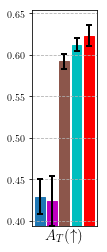

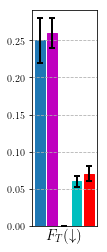

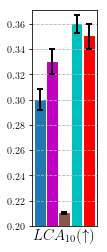

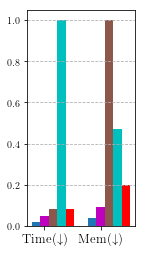

In [9]:
# CIFAR
# metadata method = [Avg_Acc, Forgetting, LCA_10, Time, Mem]
plt.clf()
metric_name = ['acc', 'fgt', 'lca10', 'time', 'memory']
ticks = ['$A_T$($\uparrow$)', '$F_T$($\downarrow$)', '$LCA_{10}$($\uparrow$)', 'Time($\downarrow$)', 
         'Mem($\downarrow$)']
labels = ['VAN', 'EWC', 'PROG-NN', 'GEM', 'A-GEM']
colors = ['C0', 'm', 'C5', 'c', 'r']
bar_data = dict()
bar_error = dict()
bar_data['VAN'] = np.array([0.429, 0.25, 0.30, 0.02, 0.04])
bar_data['EWC'] = np.array([0.424, 0.26, 0.33, 0.05, 0.09])
bar_data['PROG-NN'] = np.array([0.592, 0, 0.21, 0.08, 1])
bar_data['GEM'] = np.array([0.612, 0.06, 0.36, 1, 0.47])
bar_data['A-GEM'] = np.array([0.623, 0.07, 0.35, 0.08, 0.2])

bar_error['VAN'] = np.array([0.0207, 0.03, 0.008, 0, 0])
bar_error['EWC'] = np.array([0.0302, 0.02, 0.01, 0, 0])
bar_error['PROG-NN'] = np.array([0.0085, 0, 0.001, 0, 0])
bar_error['GEM'] = np.array([0.0078, 0.007, 0.007, 0, 0])
bar_error['A-GEM'] = np.array([0.0124, 0.01, 0.01, 0, 0])

total_metrics = 4
for metric in range(total_metrics):
    
    if metric <=2:
        fig = plt.figure(figsize=(1.5, 4))
        #fig, axes = plt.subplots(1, 5)
        ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        num_methods = len(bar_data)
        r = np.arange(0, num_methods)
        data = np.zeros(num_methods)
        yerror = np.zeros(num_methods)
        
        data[0] = bar_data['VAN'][metric]
        data[1] = bar_data['EWC'][metric]
        data[2] = bar_data['PROG-NN'][metric]
        data[3] = bar_data['GEM'][metric]
        data[4] = bar_data['A-GEM'][metric]
    
        yerror[0] = bar_error['VAN'][metric]
        yerror[1] = bar_error['EWC'][metric]
        yerror[2] = bar_error['PROG-NN'][metric]
        yerror[3] = bar_error['GEM'][metric]
        yerror[4] = bar_error['A-GEM'][metric]
        
        low = min(data)
        high = max(data)
        if metric == 1:
            ax.set_ylim(low, high+np.max(yerror)+0.001)
        else:
            ax.set_ylim(low-np.max(yerror), high+np.max(yerror)+0.001)
            
        barlist = ax.bar(r, data, yerr=yerror, error_kw=dict(lw=2, capsize=3, capthick=2))

        for i in range(num_methods):
            barlist[i].set_color(colors[i])
    
        ax.set_xlabel(ticks[metric], size=15)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        #ax.spines['right'].set_visible(False)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.yaxis.grid(linestyle='--')
        #plt.show()
        plt.savefig('iclr_plots/grouped_lll_cifar_%s.pdf'%(metric_name[metric]))
    else:
        # Metric 3        
        fig = plt.figure(figsize=(2.5, 4))
        ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
        sub_data1 = np.zeros(2)
        sub_data2 = np.zeros(2)
        sub_data3 = np.zeros(2)
        sub_data4 = np.zeros(2)
        sub_data5 = np.zeros(2)

        sub_data1 = bar_data['VAN'][3:]
        sub_data2 = bar_data['EWC'][3:]
        sub_data3 = bar_data['PROG-NN'][3:]
        sub_data4 = bar_data['GEM'][3:]
        sub_data5 = bar_data['A-GEM'][3:]

        barWidth = 0.15
        r1 = np.arange(len(sub_data1))
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        r5 = [x + barWidth for x in r4]

        plt.bar(r1, sub_data1, width=barWidth, color=colors[0])
        plt.bar(r2, sub_data2, width=barWidth, color=colors[1])
        plt.bar(r3, sub_data3, width=barWidth, color=colors[2])
        plt.bar(r4, sub_data4, width=barWidth, color=colors[3])
        plt.bar(r5, sub_data5, width=barWidth, color=colors[4])
        
        plt.xticks([r + barWidth for r in range(len(sub_data1))], [ticks[3], ticks[4]], size=13)
        ax.yaxis.grid(linestyle='--')
        #plt.show()
        plt.savefig('iclr_plots/grouped_lll_cifar_time_memory.pdf')

In [ ]:
plt.clf()
fig = plt.figure(figsize=(2,2))
ax = fig.add_axes([-0.41, 0.10, 0.4, 0.75])
patches = []
for i in range(num_methods):
        patches.append(mpatches.Patch(color=colors[i], label=labels[i]))
        plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2, 
                   fontsize='x-large')
#plt.show()
plt.savefig('iclr_plots/mnist_cifar_legend.pdf')

[0.2  0.23]


<Figure size 432x288 with 0 Axes>

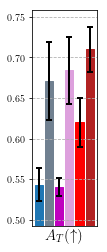

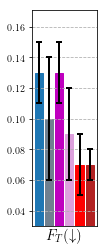

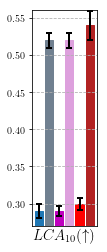

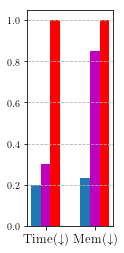

In [10]:
# CUB
# metadata method = [Avg_Acc, Forgetting, LCA_10, Time, Mem]
plt.clf()
metric_name = ['acc', 'fgt', 'lca10', 'time', 'memory']
ticks = ['$A_T$($\uparrow$)', '$F_T$($\downarrow$)', '$LCA_{10}$($\uparrow$)', 'Time($\downarrow$)', 
         'Mem($\downarrow$)']
labels = ['VAN', 'VAN-JE', 'EWC', 'EWC-JE', 'A-GEM', 'A-GEM-JE']
#colors = ['C0', 'C5', 'm', 'k', 'r', 'cyan']
colors = ['C0', 'slategray', 'm', 'plum', 'r', 'firebrick']

bar_data = dict()
bar_error = dict()

bar_data['VAN'] = np.array([0.543, 0.13, 0.29, 0.2, 0.23])
bar_data['VAN-JE'] = np.array([0.671, 0.10, 0.52])
bar_data['EWC'] = np.array([0.54, 0.13, 0.29, 0.3, 0.85])
bar_data['EWC-JE'] = np.array([0.684, 0.09, 0.52])
bar_data['A-GEM'] = np.array([0.62, 0.07, 0.30, 1, 1])
bar_data['A-GEM-JE'] = np.array([0.71, 0.07, 0.54])

bar_error['VAN'] = np.array([0.0203, 0.02, 0.009])
bar_error['VAN-JE'] = np.array([0.0477, 0.04, 0.01])
bar_error['EWC'] = np.array([0.0108, 0.02, 0.007])
bar_error['EWC-JE'] = np.array([0.0408, 0.03, 0.01])
bar_error['A-GEM'] = np.array([0.03, 0.02, 0.008])
bar_error['A-GEM-JE'] = np.array([0.028, 0.01, 0.02])

# Metric 0        
fig = plt.figure(figsize=(1.5, 4))
ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
metric=0
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
num_methods = len(bar_data)
r = np.arange(0, num_methods)
data = np.zeros(num_methods)
yerror = np.zeros(num_methods)

data[0] = bar_data['VAN'][metric]
data[1] = bar_data['VAN-JE'][metric]
data[2] = bar_data['EWC'][metric]
data[3] = bar_data['EWC-JE'][metric]
data[4] = bar_data['A-GEM'][metric]
data[5] = bar_data['A-GEM-JE'][metric]

yerror[0] = bar_error['VAN'][metric]
yerror[1] = bar_error['VAN-JE'][metric]
yerror[2] = bar_error['EWC'][metric]
yerror[3] = bar_error['EWC-JE'][metric]
yerror[4] = bar_error['A-GEM'][metric]
yerror[5] = bar_error['A-GEM-JE'][metric]

low = min(data)
high = max(data)
#ax.set_ylim(low-0.005, high+0.005)
ax.set_ylim(low-np.max(yerror), high+np.max(yerror)+0.001)
barlist = ax.bar(r, data, yerr=yerror, error_kw=dict(lw=2, capsize=3, capthick=2))
for i in range(num_methods):
    barlist[i].set_color(colors[i])
    
ax.set_xlabel(ticks[metric], size=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.yaxis.grid(linestyle='--')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig('iclr_plots/grouped_lll_cub_%s.pdf'%(metric_name[metric]))

# Metric 1        
fig = plt.figure(figsize=(1.5, 4))
ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
metric=1
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
num_methods = len(bar_data)
r = np.arange(0, num_methods)
data = np.zeros(num_methods)
yerror = np.zeros(num_methods)

data[0] = bar_data['VAN'][metric]
data[1] = bar_data['VAN-JE'][metric]
data[2] = bar_data['EWC'][metric]
data[3] = bar_data['EWC-JE'][metric]
data[4] = bar_data['A-GEM'][metric]
data[5] = bar_data['A-GEM-JE'][metric]

yerror[0] = bar_error['VAN'][metric]
yerror[1] = bar_error['VAN-JE'][metric]
yerror[2] = bar_error['EWC'][metric]
yerror[3] = bar_error['EWC-JE'][metric]
yerror[4] = bar_error['A-GEM'][metric]
yerror[5] = bar_error['A-GEM-JE'][metric]

low = min(data)
high = max(data)
#ax.set_ylim(low-0.003, high+0.001)
ax.set_ylim(low-np.max(yerror), high+np.max(yerror)+0.001)
barlist = ax.bar(r, data, yerr=yerror, error_kw=dict(lw=2, capsize=3, capthick=2))
for i in range(num_methods):
    barlist[i].set_color(colors[i])
    
ax.set_xlabel(ticks[metric], size=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.yaxis.grid(linestyle='--')
plt.savefig('iclr_plots/grouped_lll_cub_%s.pdf'%(metric_name[metric]))

# Metric 2        
fig = plt.figure(figsize=(1.5, 4))
ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
metric=2
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
num_methods = len(bar_data)
r = np.arange(0, num_methods)
data = np.zeros(num_methods)
yerror = np.zeros(num_methods)

data[0] = bar_data['VAN'][metric]
data[1] = bar_data['VAN-JE'][metric]
data[2] = bar_data['EWC'][metric]
data[3] = bar_data['EWC-JE'][metric]
data[4] = bar_data['A-GEM'][metric]
data[5] = bar_data['A-GEM-JE'][metric]

yerror[0] = bar_error['VAN'][metric]
yerror[1] = bar_error['VAN-JE'][metric]
yerror[2] = bar_error['EWC'][metric]
yerror[3] = bar_error['EWC-JE'][metric]
yerror[4] = bar_error['A-GEM'][metric]
yerror[5] = bar_error['A-GEM-JE'][metric]

low = min(data)
high = max(data)
ax.set_ylim(low-np.max(yerror), high+np.max(yerror)+0.001)
barlist = ax.bar(r, data, yerr=yerror, error_kw=dict(lw=2, capsize=3, capthick=2))
for i in range(num_methods):
    barlist[i].set_color(colors[i])
    
ax.set_xlabel(ticks[metric], size=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.yaxis.grid(linestyle='--')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig('iclr_plots/grouped_lll_cub_%s.pdf'%(metric_name[metric]))

# Metric 3        
fig = plt.figure(figsize=(2, 4))
ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
sub_data1 = np.zeros(2)
sub_data2 = np.zeros(2)
sub_data3 = np.zeros(2)

sub_data1 = bar_data['VAN'][3:]
sub_data2 = bar_data['EWC'][3:]
sub_data3 = bar_data['A-GEM'][3:]

print(sub_data1)
barWidth = 0.20
r1 = np.arange(len(sub_data1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

#ax.set_ylim(0.2-0.01, 1)

plt.bar(r1, sub_data1, width=barWidth, color=colors[0])
plt.bar(r2, sub_data2, width=barWidth, color=colors[2])
plt.bar(r3, sub_data3, width=barWidth, color=colors[4])
        
plt.xticks([r + barWidth for r in range(len(sub_data1))], [ticks[3], ticks[4]], size=13)
#ax = plt.axes()        
ax.yaxis.grid(linestyle='--')
plt.savefig('iclr_plots/grouped_lll_cub_time_memory.pdf')


[0.04 0.08]


<Figure size 432x288 with 0 Axes>

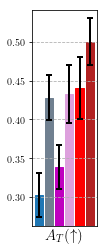

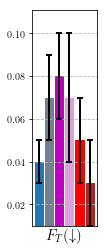

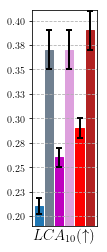

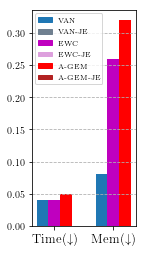

In [11]:
# AWA
# metadata method = [Avg_Acc, Forgetting, LCA_10, Mem]
plt.clf()
metric = 4
metric_name = ['acc', 'fgt', 'lca10', 'time', 'memory']
ticks = ['$A_T$($\uparrow$)', '$F_T$($\downarrow$)', '$LCA_{10}$($\uparrow$)', 'Time($\downarrow$)', 
         'Mem($\downarrow$)']
labels = ['VAN', 'VAN-JE', 'EWC', 'EWC-JE', 'A-GEM', 'A-GEM-JE']
#colors = ['C0', 'C5', 'm', 'k', 'r', 'cyan']
colors = ['C0', 'slategray', 'm', 'plum', 'r', 'firebrick']

bar_data = dict()
bar_error = dict()

bar_data['VAN'] = np.array([0.303, 0.04, 0.21, 0.04, 0.08])
bar_data['VAN-JE'] = np.array([0.428, 0.07, 0.37])
bar_data['EWC'] = np.array([0.339, 0.08, 0.26, 0.04, 0.26])
bar_data['EWC-JE'] = np.array([0.433, 0.07, 0.37])
bar_data['A-GEM'] = np.array([0.44, 0.05, 0.29, 0.05, 0.32])
bar_data['A-GEM-JE'] = np.array([0.50, 0.03, 0.39])

bar_error['VAN'] = np.array([0.0284, 0.01, 0.008])
bar_error['VAN-JE'] = np.array([0.0286, 0.02, 0.02])
bar_error['EWC'] = np.array([0.0287, 0.02, 0.01])
bar_error['EWC-JE'] = np.array([0.0371, 0.03, 0.02])
bar_error['A-GEM'] = np.array([0.04, 0.02, 0.01])
bar_error['A-GEM-JE'] = np.array([0.03, 0.02, 0.02])

# Metric 0        
fig = plt.figure(figsize=(1.5, 4))
ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
metric=0
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
num_methods = len(bar_data)
r = np.arange(0, num_methods)
data = np.zeros(num_methods)
yerror = np.zeros(num_methods)
data[0] = bar_data['VAN'][metric]
data[1] = bar_data['VAN-JE'][metric]
data[2] = bar_data['EWC'][metric]
data[3] = bar_data['EWC-JE'][metric]
data[4] = bar_data['A-GEM'][metric]
data[5] = bar_data['A-GEM-JE'][metric]

yerror[0] = bar_error['VAN'][metric]
yerror[1] = bar_error['VAN-JE'][metric]
yerror[2] = bar_error['EWC'][metric]
yerror[3] = bar_error['EWC-JE'][metric]
yerror[4] = bar_error['A-GEM'][metric]
yerror[5] = bar_error['A-GEM-JE'][metric]

low = min(data)
high = max(data)
#ax.set_ylim(low-0.005, high+0.005)
ax.set_ylim(low-np.max(yerror), high+np.max(yerror)+0.001)
barlist = ax.bar(r, data, yerr=yerror, error_kw=dict(lw=2, capsize=3, capthick=2))
for i in range(num_methods):
    barlist[i].set_color(colors[i])
    
ax.set_xlabel(ticks[metric], size=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.grid(linestyle='--')
plt.savefig('iclr_plots/grouped_lll_awa_%s.pdf'%(metric_name[metric]))

# Metric 1        
fig = plt.figure(figsize=(1.5, 4))
ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
metric=1
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
num_methods = len(bar_data)
r = np.arange(0, num_methods)
data = np.zeros(num_methods)
yerror = np.zeros(num_methods)
data[0] = bar_data['VAN'][metric]
data[1] = bar_data['VAN-JE'][metric]
data[2] = bar_data['EWC'][metric]
data[3] = bar_data['EWC-JE'][metric]
data[4] = bar_data['A-GEM'][metric]
data[5] = bar_data['A-GEM-JE'][metric]

yerror[0] = bar_error['VAN'][metric]
yerror[1] = bar_error['VAN-JE'][metric]
yerror[2] = bar_error['EWC'][metric]
yerror[3] = bar_error['EWC-JE'][metric]
yerror[4] = bar_error['A-GEM'][metric]
yerror[5] = bar_error['A-GEM-JE'][metric]

low = min(data)
high = max(data)
#ax.set_ylim(low-0.003, high+0.001)
ax.set_ylim(0.01, high+np.max(yerror)+0.001)
#ax.set_ylim(low, high+np.max(yerror)+0.001)
barlist = ax.bar(r, data, yerr=yerror, error_kw=dict(lw=2, capsize=3, capthick=2))
for i in range(num_methods):
    barlist[i].set_color(colors[i])
    
ax.set_xlabel(ticks[metric], size=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.yaxis.grid(linestyle='--')
plt.savefig('iclr_plots/grouped_lll_awa_%s.pdf'%(metric_name[metric]))

# Metric 2        
fig = plt.figure(figsize=(1.5, 4))
ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
metric=2
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
num_methods = len(bar_data)
r = np.arange(0, num_methods)
data = np.zeros(num_methods)
yerror = np.zeros(num_methods)
data[0] = bar_data['VAN'][metric]
data[1] = bar_data['VAN-JE'][metric]
data[2] = bar_data['EWC'][metric]
data[3] = bar_data['EWC-JE'][metric]
data[4] = bar_data['A-GEM'][metric]
data[5] = bar_data['A-GEM-JE'][metric]

yerror[0] = bar_error['VAN'][metric]
yerror[1] = bar_error['VAN-JE'][metric]
yerror[2] = bar_error['EWC'][metric]
yerror[3] = bar_error['EWC-JE'][metric]
yerror[4] = bar_error['A-GEM'][metric]
yerror[5] = bar_error['A-GEM-JE'][metric]

low = min(data)
high = max(data)
#ax.set_ylim(low-0.005, high+0.005)
ax.set_ylim(low-np.max(yerror), high+np.max(yerror)+0.001)
barlist = ax.bar(r, data, yerr=yerror, error_kw=dict(lw=2, capsize=3, capthick=2))
for i in range(num_methods):
    barlist[i].set_color(colors[i])
    
ax.set_xlabel(ticks[metric], size=15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.yaxis.grid(linestyle='--')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig('iclr_plots/grouped_lll_awa_%s.pdf'%(metric_name[metric]))

# Metric 3  
fig = plt.figure(figsize=(2.4, 4))
ax = fig.add_axes([0.24, 0.15, 0.6, 0.75])
sub_data1 = np.zeros(2)
sub_data2 = np.zeros(2)
sub_data3 = np.zeros(2)

sub_data1 = bar_data['VAN'][3:]
sub_data2 = bar_data['EWC'][3:]
sub_data3 = bar_data['A-GEM'][3:]

print(sub_data1)
barWidth = 0.20
r1 = np.arange(len(sub_data1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, sub_data1, width=barWidth, color=colors[0])
plt.bar(r2, sub_data2, width=barWidth, color=colors[2])
plt.bar(r3, sub_data3, width=barWidth, color=colors[4])
 
patches = []
for i in range(num_methods):
        patches.append(mpatches.Patch(color=colors[i], label=labels[i]))
        plt.legend(handles=patches, loc='best',  
                  fontsize='x-small')
        
plt.xticks([r + barWidth for r in range(len(sub_data1))], [ticks[3], ticks[4]], size=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.grid(linestyle='--')
#plt.legend(loc='best')
plt.savefig('iclr_plots/grouped_lll_awa_time_memory.pdf')

<Figure size 432x288 with 0 Axes>

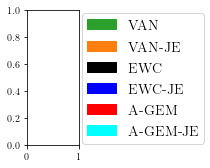

In [90]:
plt.clf()
fig = plt.figure(figsize=(1.8,2.5))
ax = fig.add_axes([-0.41, 0.15, 0.4, 0.75])
patches = []
for i in range(num_methods):
        patches.append(mpatches.Patch(color=colors[i], label=labels[i]))
        plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2, 
                  fontsize='x-large')
#plt.show()
plt.savefig('iclr_plots/awa_cub_legend.pdf')

In [88]:
colors

<module 'matplotlib.colors' from '/anaconda2/lib/python2.7/site-packages/matplotlib/colors.pyc'>